In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gc
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import warnings
warnings.filterwarnings("ignore")

In [17]:
def build_df(LST_no_sensor, subject):    
    path = './DB_A_preproceesed/'  

    file_list = os.listdir(path)

    for gesture in range(1,9):
        for trial in range(1,10): #trial 1~9
            globals()['data_S{}_G{}_T{}'.format(subject, gesture, trial)] = scipy.io.loadmat(
                path + file_list[subject-1] + '/0{}-00{}-00{}.mat'.format(subject, gesture, trial)
            )['data'].T
                                                            
    for gesture in range(1,9): #trial 10
        globals()['data_S{}_G{}_T10'.format(subject, gesture)] = scipy.io.loadmat(
            path + file_list[subject-1] + '/0{}-00{}-010.mat'.format(subject, gesture)
        )['data'].T
                                                            

    div_len = 1000 
    total_data, label_lst = [], []
    list_trials = np.sort(random.sample(np.arange(1,11).tolist(), 3)).tolist() #  3개 제스쳐 고름

    for gesture in range(1,9):
        for trial in list_trials:
            for idx in range(1):  #250 * 4 = 1000
                for sensor in LST_no_sensor: 
                    data_tmp = globals()['data_S{}_G{}_T{}'.format(subject, gesture, trial)][sensor][div_len*idx:div_len*(idx+1)].tolist()
                    total_data.append(data_tmp) 
                    label_lst.append(gesture-1)

    df = pd.DataFrame(total_data)
    df['Label'] = label_lst
    
    return df

In [3]:
def build_graph_works_larger_than_16(df, LST_no_sensor):
    electrodes = {}
    row_sensor = 8
    for i in range(row_sensor,len(LST_no_sensor)-row_sensor):
        if i%8 == 0: electrodes['lst_{}'.format(i)]=[i-row_sensor, i-(row_sensor-1), i+1, i+row_sensor, i+row_sensor+1]

        elif i%8 == 7: electrodes['lst_{}'.format(i)]=[i-row_sensor, i-(row_sensor+1), i-1, i+(row_sensor-1), i+row_sensor]

        else: electrodes['lst_{}'.format(i)]=[i-(row_sensor+1), i-row_sensor, i-(row_sensor-1), 
                                             i-1, i+1, i+(row_sensor-1), i+row_sensor, i+row_sensor+1]

    for i in range(row_sensor):
        if i==0: electrodes['lst_{}'.format(i)]=[1,row_sensor,row_sensor+1,len(LST_no_sensor)-row_sensor,len(LST_no_sensor)-row_sensor+1]
        elif i==row_sensor-1: electrodes['lst_{}'.format(i)]=[row_sensor-2,row_sensor*2-2,row_sensor*2-1,len(LST_no_sensor)-2,len(LST_no_sensor)-1]
        else: electrodes['lst_{}'.format(i)]=[i-1, i+1, i+row_sensor-1, i+row_sensor, i+row_sensor+1, i+len(LST_no_sensor)-row_sensor-1, i+len(LST_no_sensor)-row_sensor, i+len(LST_no_sensor)-row_sensor+1]

    for i in range(len(LST_no_sensor)-row_sensor, len(LST_no_sensor)):  
        if i==len(LST_no_sensor)-row_sensor: electrodes['lst_{}'.format(i)]=[i-row_sensor,i-row_sensor+1,i+1,0,1]
        elif i==len(LST_no_sensor)-1: electrodes['lst_{}'.format(i)]=[i-row_sensor-1, i-row_sensor, i-1, row_sensor-2, row_sensor-1]
        else: electrodes['lst_{}'.format(i)]=[i-1, i-row_sensor-1, i-row_sensor, i-row_sensor+1, i+1, i-len(LST_no_sensor)-row_sensor+1, i-len(LST_no_sensor), i-len(LST_no_sensor)-row_sensor-1]
    
    for i in range(row_sensor):
        if i%row_sensor==0: electrodes['lst_{}'.format(i)]=[2,row_sensor+2,0,1,row_sensor+4] 
        elif i%row_sensor==1: electrodes['lst_{}'.format(i)]=[3,row_sensor+3,0,1,2,3,row_sensor+5] 
        elif i%row_sensor==6: electrodes['lst_{}'.format(i)]=[4,row_sensor+4,row_sensor-3,row_sensor-2,row_sensor-1,row_sensor,row_sensor+1,row_sensor+2,row_sensor+3]  
        elif i%row_sensor==7: electrodes['lst_{}'.format(i)]=[5,row_sensor+5,row_sensor-2,row_sensor-1,3,row_sensor+3,row_sensor+2,row_sensor+1]

    for i in range(8,16):
        if i%row_sensor==0: electrodes['lst_{}'.format(i)]=[2,row_sensor+2,row_sensor,row_sensor+1,row_sensor+2,row_sensor-2,row_sensor-3,4]
        elif i%row_sensor==1: electrodes['lst_{}'.format(i)]=[3,row_sensor+3,3,row_sensor,row_sensor+1,row_sensor+2,row_sensor+3,row_sensor-1,row_sensor-2,row_sensor-3]
        elif i%row_sensor==(row_sensor-2): electrodes['lst_{}'.format(i)]=[4,row_sensor+4,row_sensor+5,row_sensor+6,row_sensor+7,3,2,1]
        elif i%row_sensor==(row_sensor-1): electrodes['lst_{}'.format(i)]=[5,row_sensor+5,row_sensor+6,row_sensor+7,3,2,1]
            
    lst_tmp_1, lst_tmp_2, num_cnt = [], [], 0

    for sensors in range(len(LST_no_sensor)):
        for i in range(len(electrodes['lst_{}'.format(sensors)])):
            lst_tmp_1.append(sensors)
            lst_tmp_2.append(electrodes['lst_{}'.format(sensors)][i])

    lst1_final, lst2_final = [], []

    lst1_final = lst1_final + lst_tmp_1 #처음 은 +127안해줌
    lst2_final = lst2_final + lst_tmp_2

    for i in range(int(len(df)/len(LST_no_sensor))-1):
        for idx in range(len(lst_tmp_1)):
            lst_tmp_1[idx] = lst_tmp_1[idx] + len(LST_no_sensor)
            lst_tmp_2[idx] = lst_tmp_2[idx] + len(LST_no_sensor)   

        lst1_final = lst1_final + lst_tmp_1
        lst2_final = lst2_final + lst_tmp_2
        
        for k in range(len(LST_no_sensor)):  #SW 부분
            lst2_final.append((i+1)*len(LST_no_sensor) + k)  #128, 129
            lst1_final.append(num_cnt)
            num_cnt = num_cnt + 1

    graph1 = pd.DataFrame({'source':lst1_final, 'target':lst2_final })
    train_data = df.sample(frac=1)
    feature_names = list(set(df.columns) - {"Label"})7
    x_train = train_data[feature_names].to_numpy()
    y_train = train_data["Label"]

    edges = graph1[["source", "target"]].to_numpy().T
    edge_weights = tf.ones(shape=edges.shape[1])
    node_features = tf.cast(df[feature_names].to_numpy(), dtype=tf.dtypes.float32)
    graph_info = (node_features, edges, edge_weights) # Create graph info tuple with node_features, edges, and edge_weights.

    print("Edges shape:", edges.shape, "     Nodes shape:", node_features.shape)
    
    x_train = train_data.index.to_numpy()
    
    return graph1, graph_info, x_train, y_train

In [4]:
def draw_graph(graph1):
    import networkx as nx

    plt.figure(figsize=(6, 6))
    cora_graph = nx.from_pandas_edgelist(graph1[:300])
    nx.draw_spring(cora_graph, node_size=10, node_color='blue')

    import gc
    gc.collect()

In [5]:
def plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"], marker='o', markersize=2)
    ax1.plot(history.history["val_loss"], marker='o', markersize=2)
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid() 
    
    ax2.plot(history.history["acc"], marker='o', markersize=2)
    ax2.plot(history.history["val_acc"], marker='o', markersize=2)
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.grid() 
    
    plt.show()

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
def build_gnn_model(graph_metadata, num_classes, hidden_units, dropout_rate):
    import model
    
    GCN = model.GNNNodeClassifier(
        graph_info=graph_metadata,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="GCN_Capgmyo type B",
    )
    
    GCN.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    
    return GCN

In [12]:
hidden_units_GRU = 256 #[128, 128]
hidden_units = [128, 128]
learning_rate = 0.002
dropout_rate = 0.15
num_epochs = 50
batch_size = 128
num_classes = 8

# Training per Row

Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


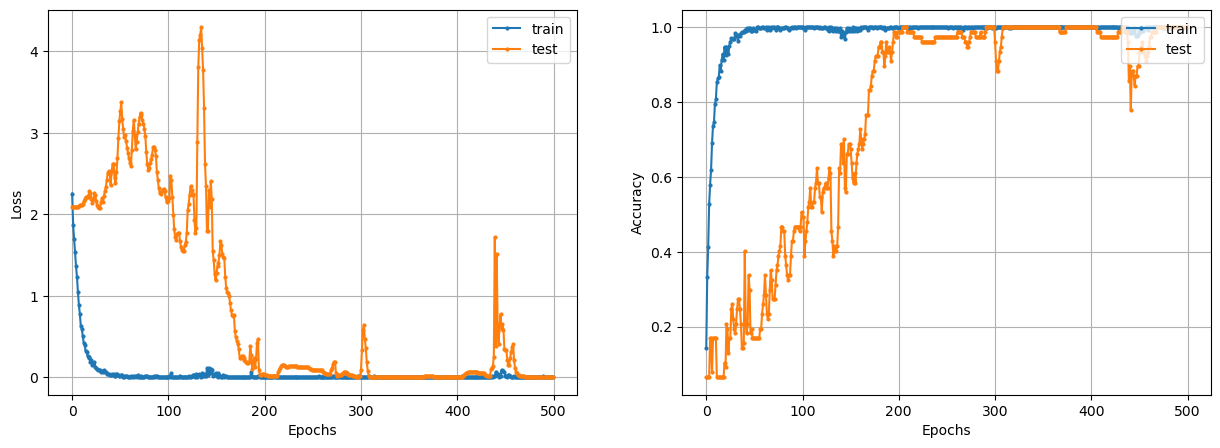

1.0 0.0004646576417144388
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


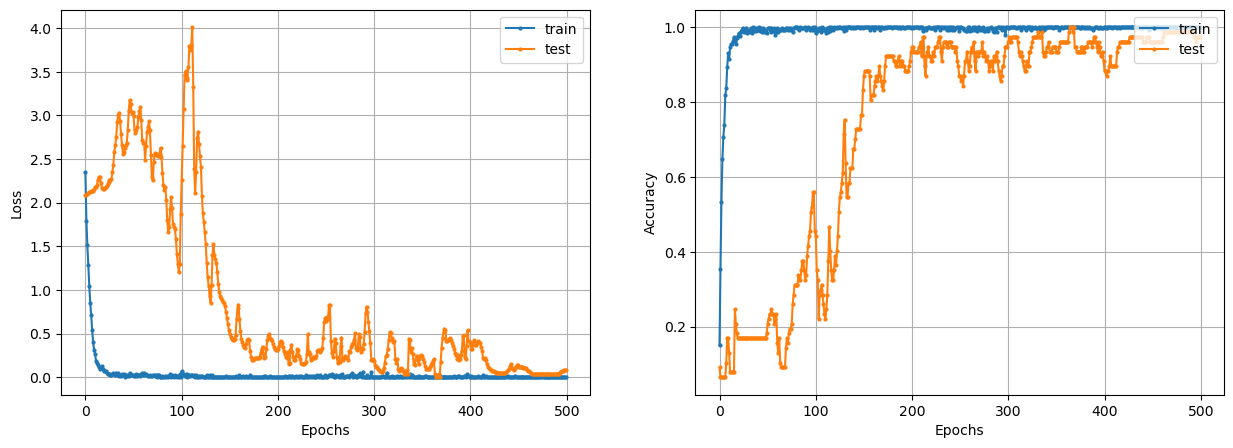

1.0 0.002158111659809947
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


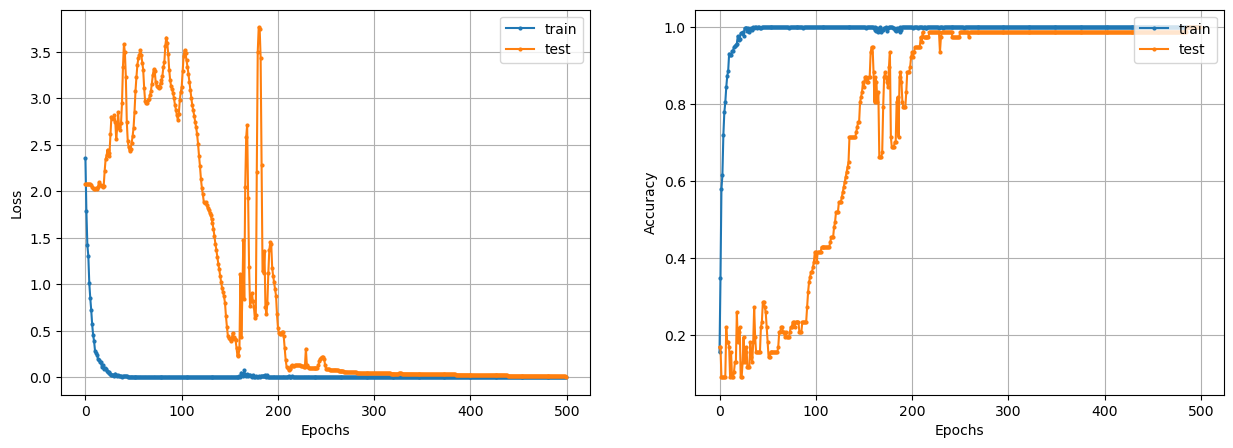

1.0 0.007728795055299997
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


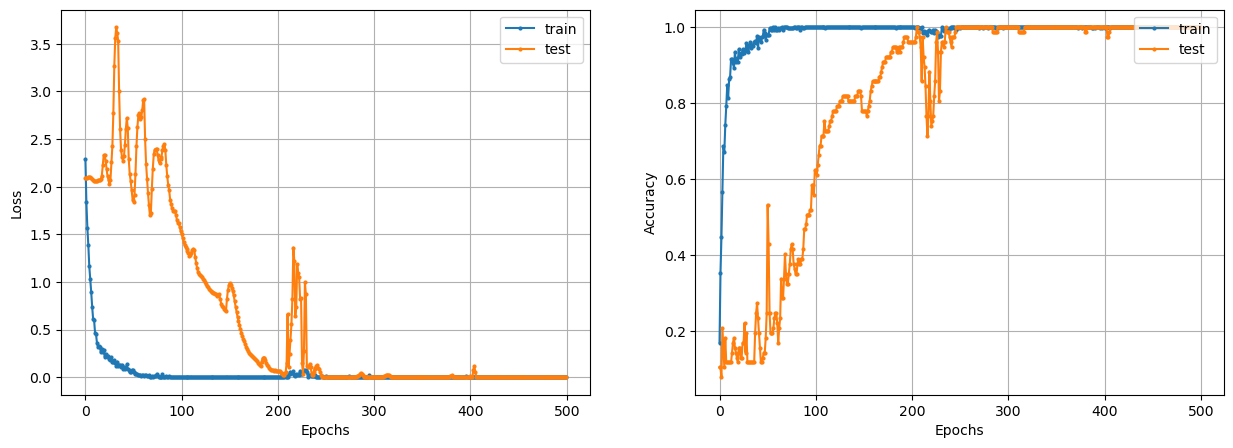

1.0 5.0353934057056904e-05
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


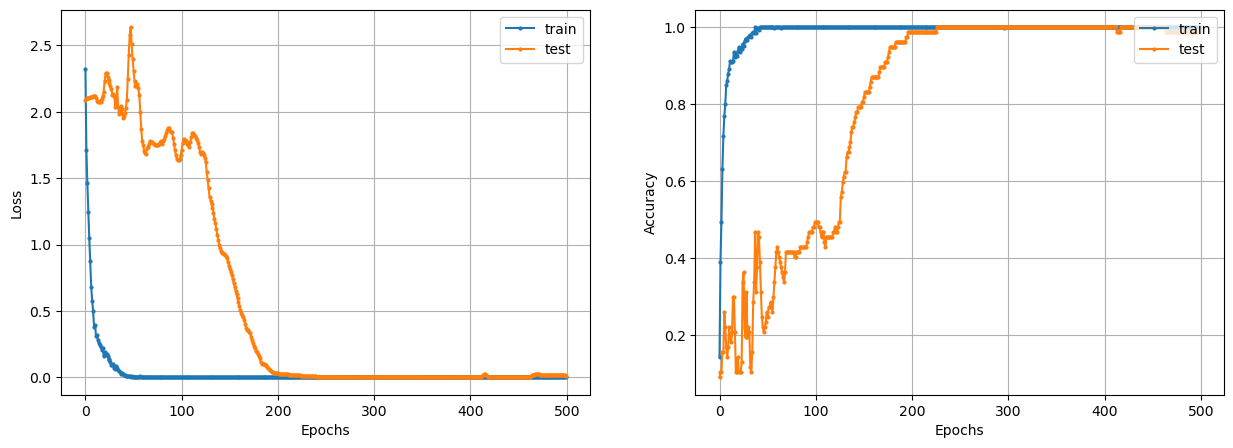

1.0 0.0006905996124260128
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


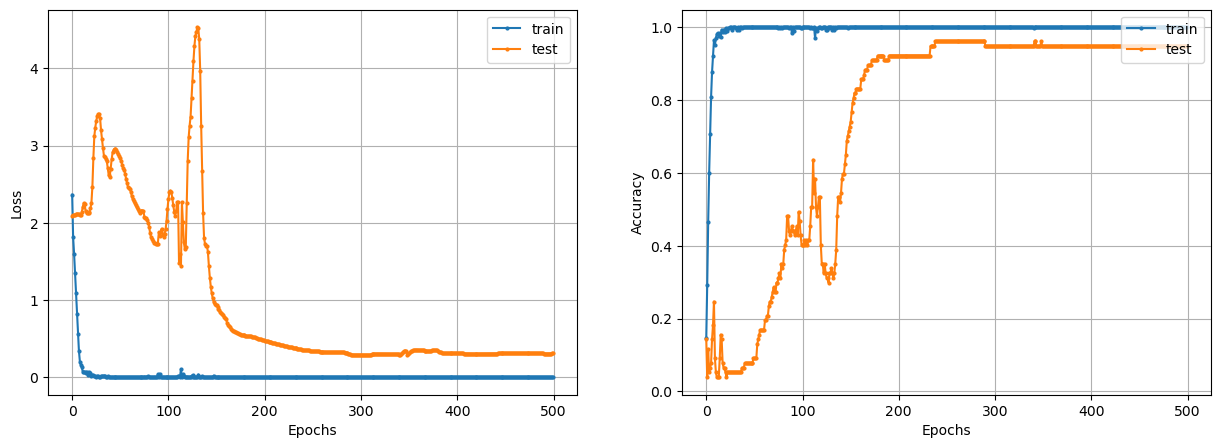

0.9610389471054077 0.28975480794906616
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


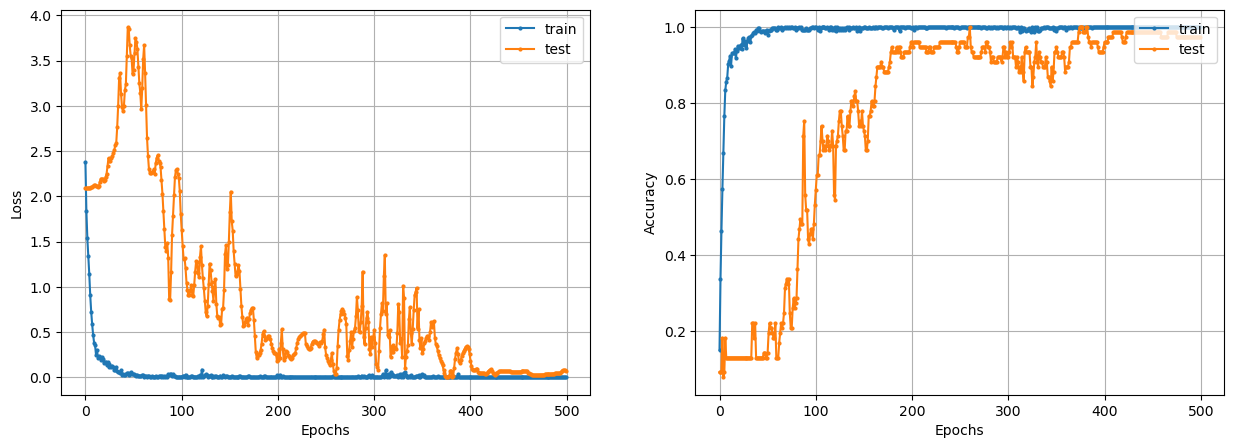

1.0 0.0004900405765511096
Start subject 15, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


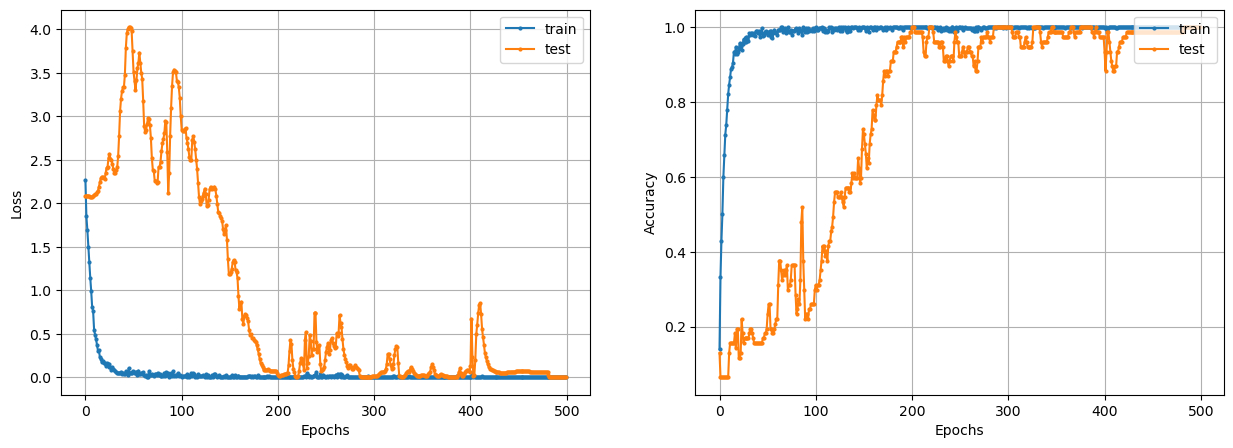

1.0 0.0003676445339806378
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


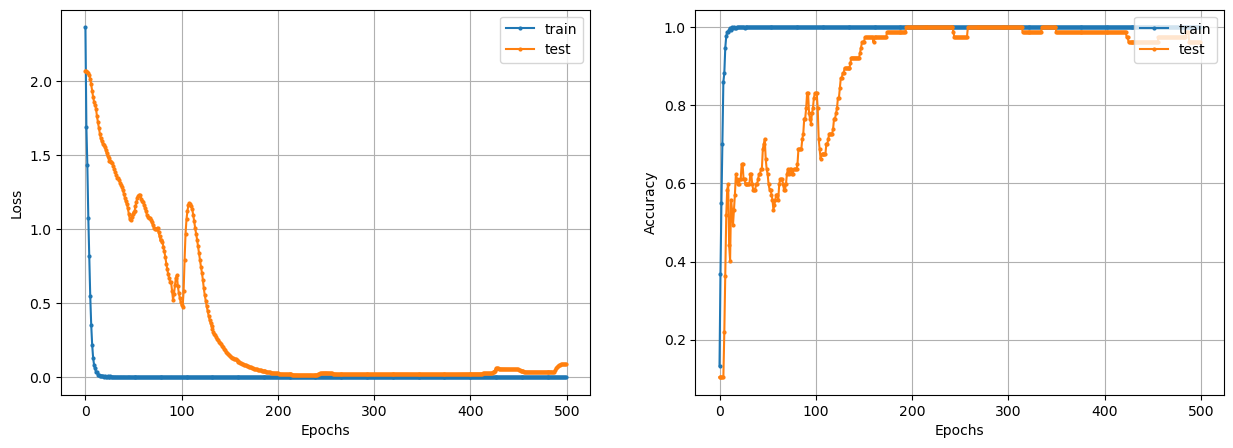

1.0 0.012239082716405392
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


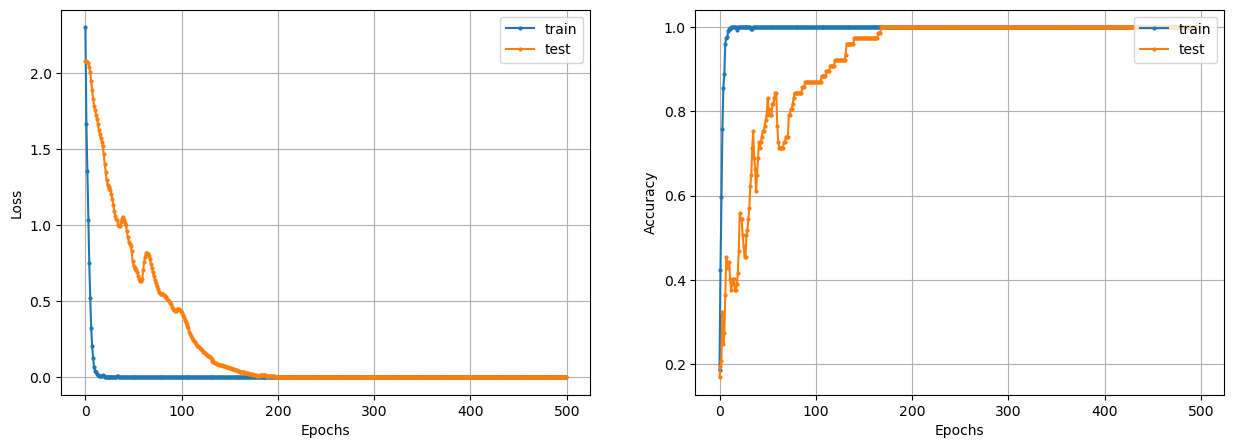

1.0 8.79930958035402e-05
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


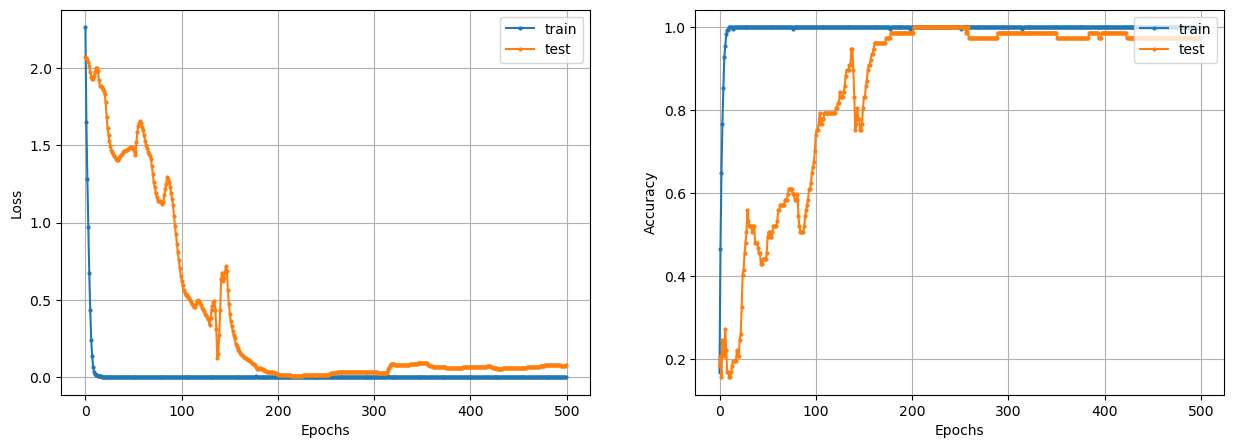

1.0 0.010300910100340843
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


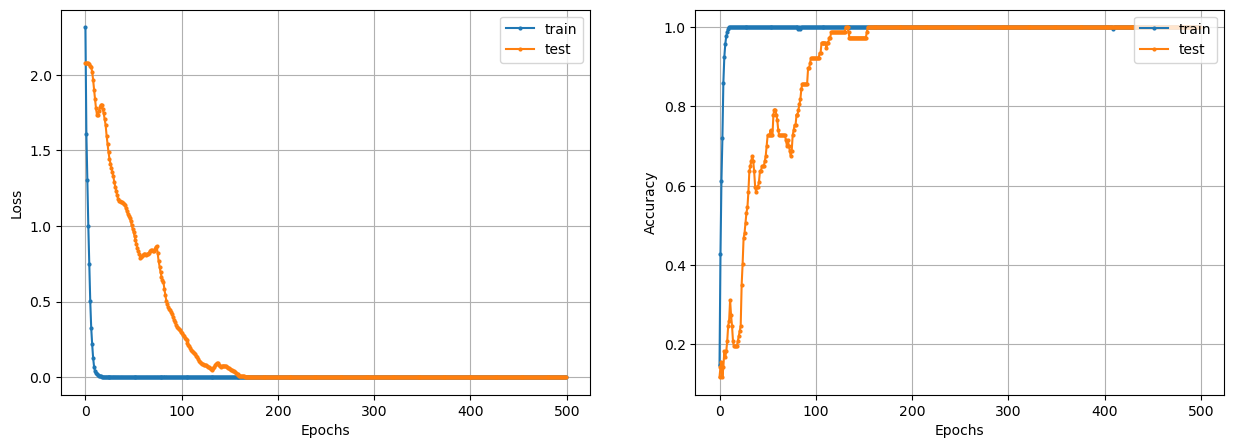

1.0 5.750024865847081e-05
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


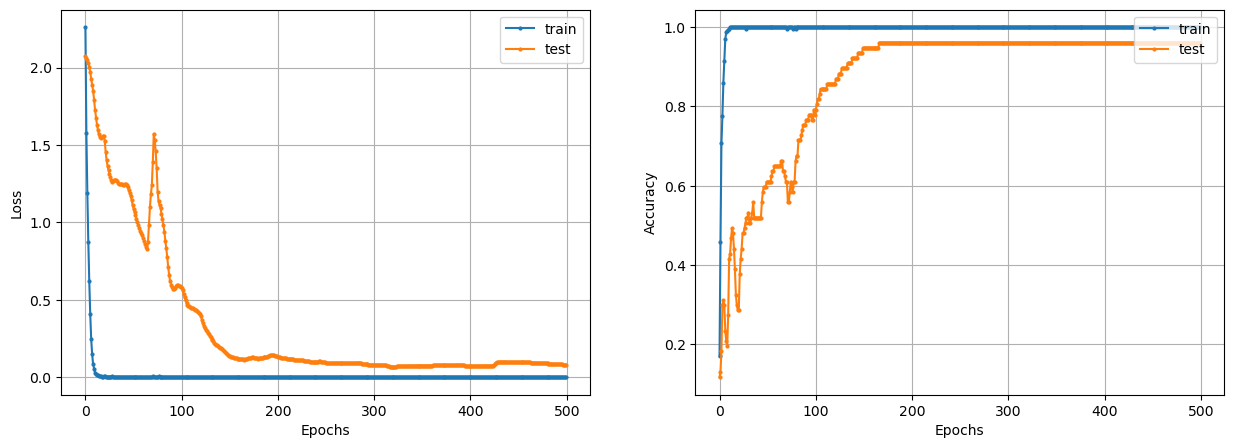

0.9610389471054077 0.06588145345449448
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


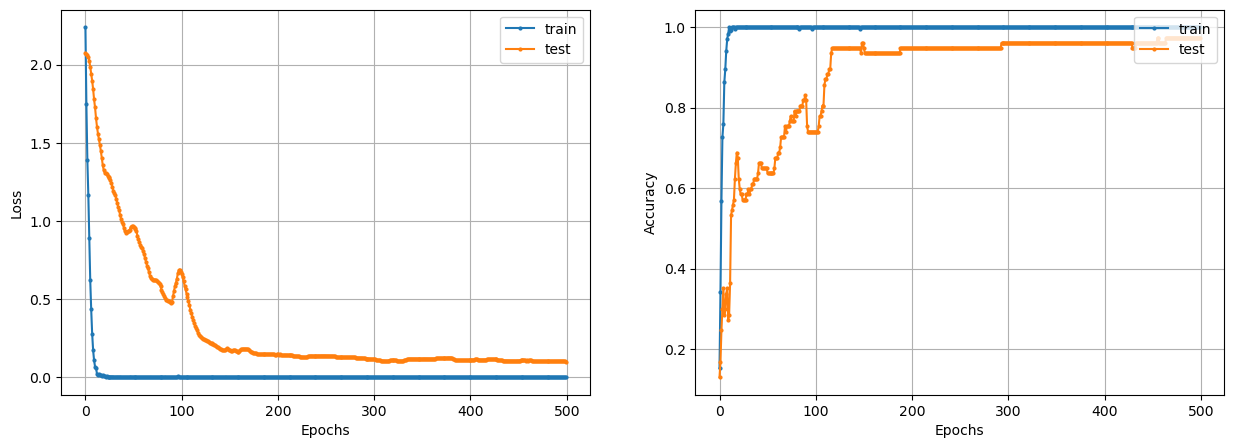

0.9740259647369385 0.09958266466856003
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


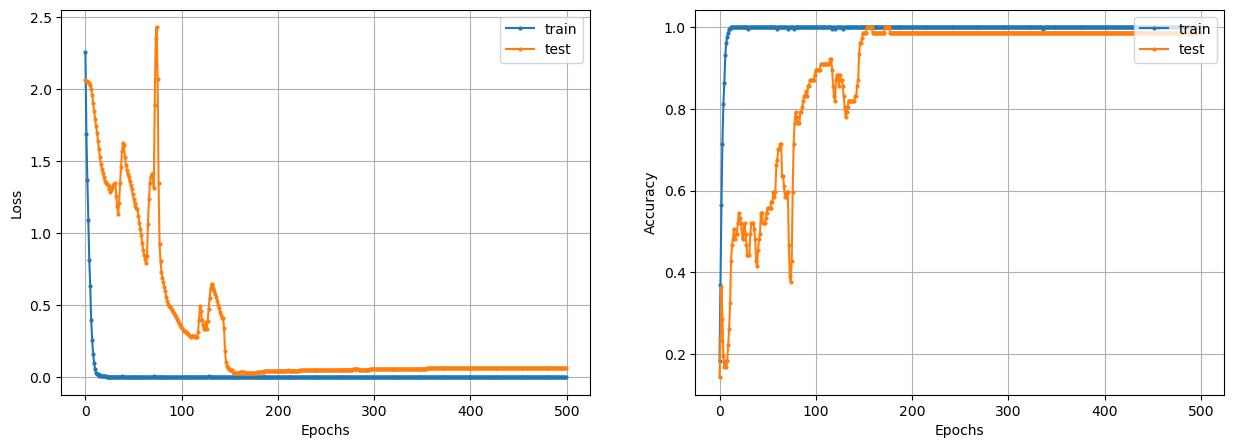

1.0 0.02854454144835472
Start subject 16, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


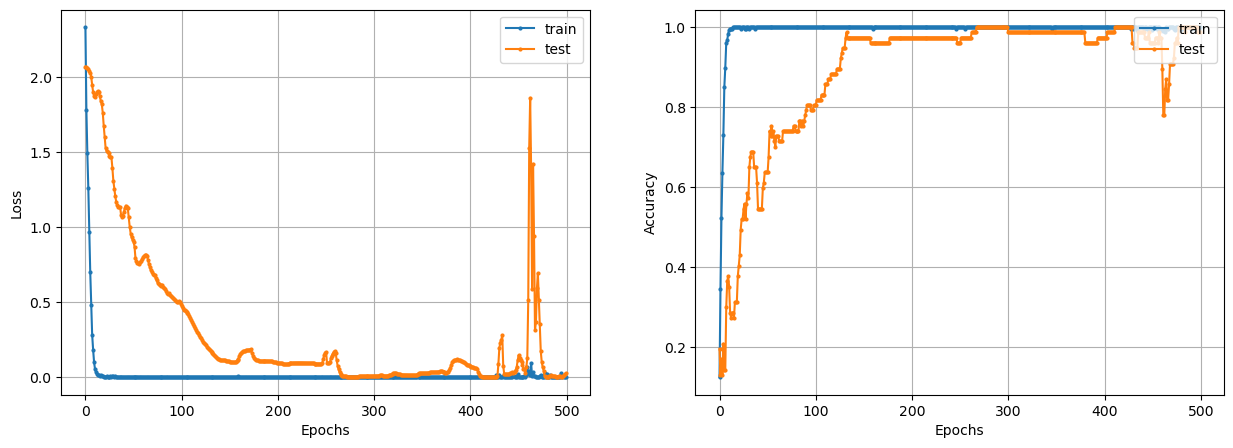

1.0 0.0007425017538480461
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


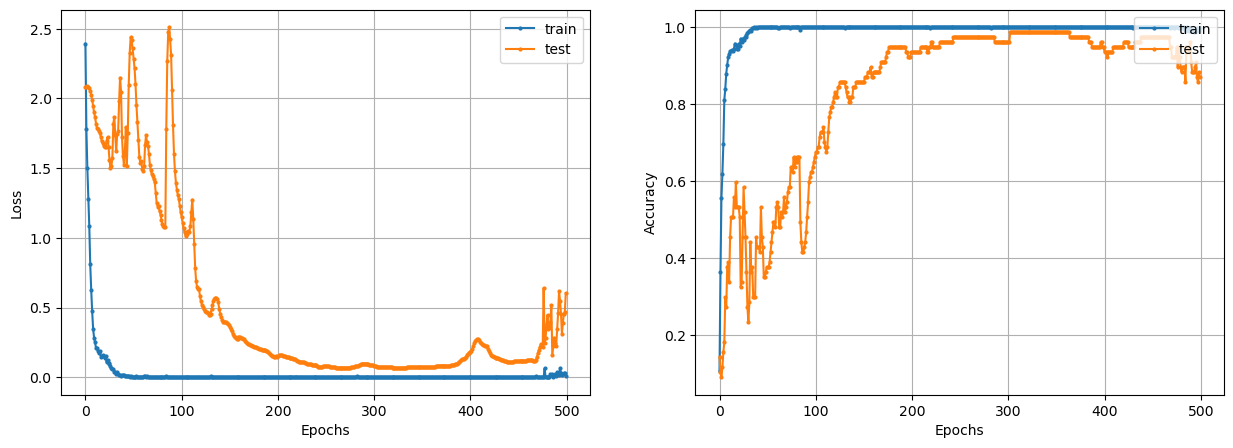

0.9870129823684692 0.0673987865447998
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


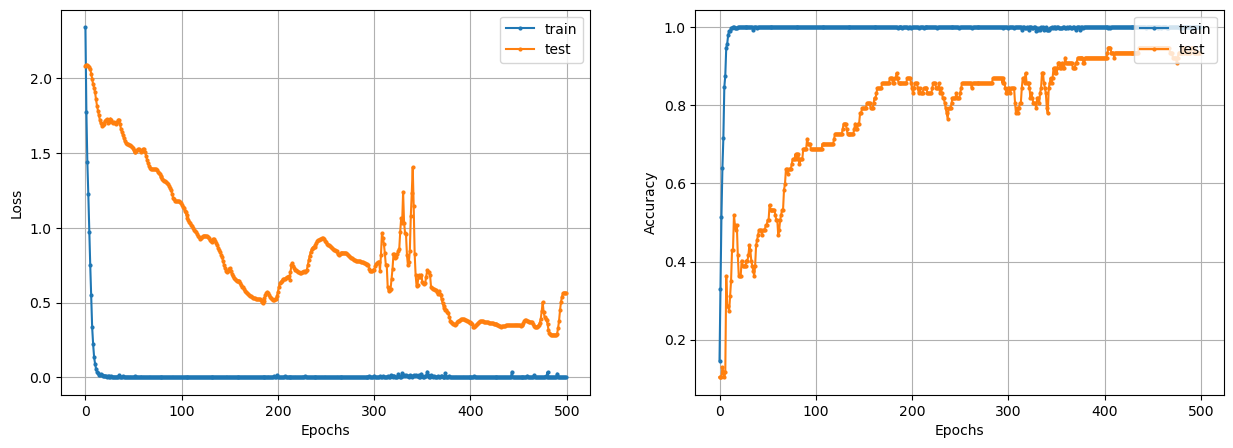

0.948051929473877 0.28105953335762024
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


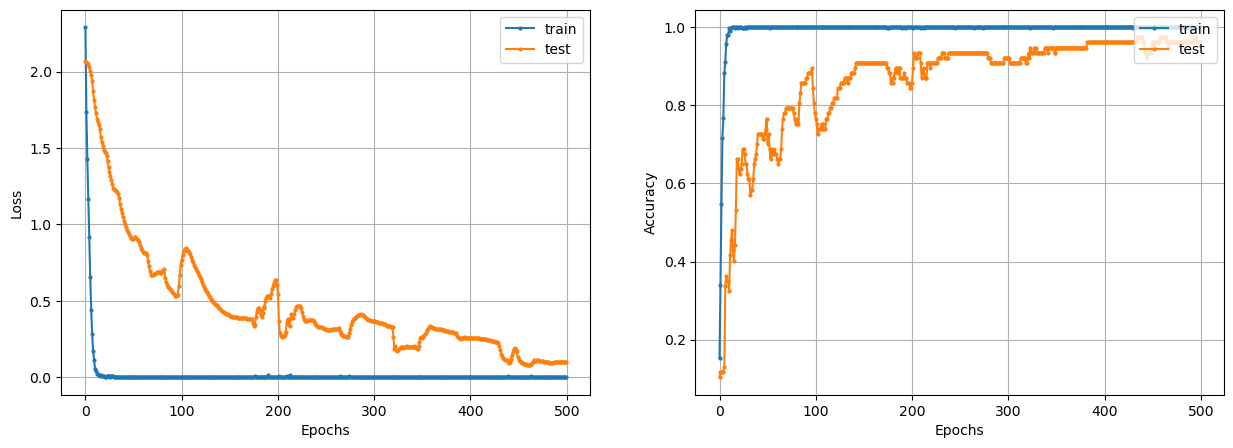

0.9740259647369385 0.08187777549028397
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


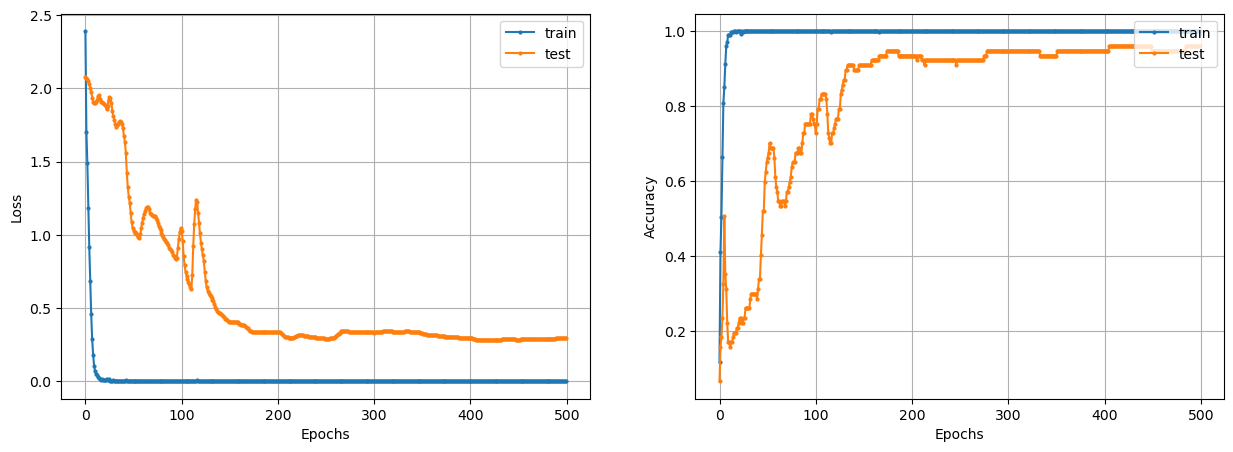

0.9610389471054077 0.28132519125938416
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


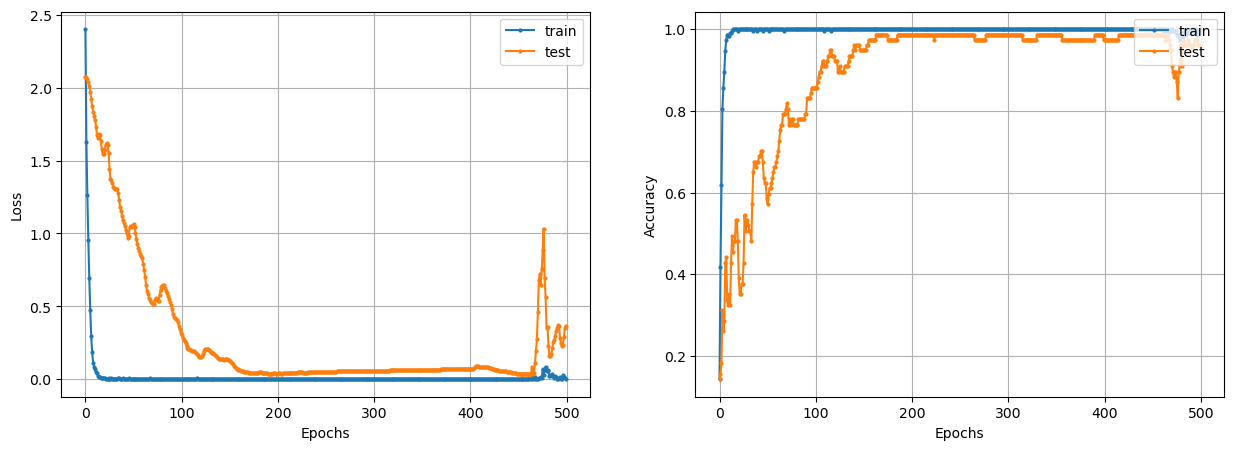

0.9870129823684692 0.0316036231815815
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


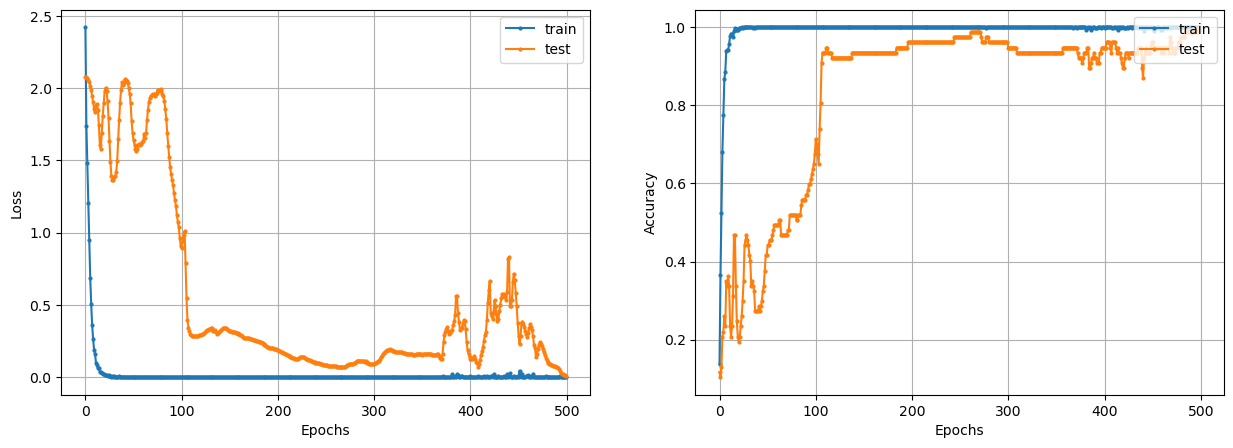

1.0 0.010566947050392628
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


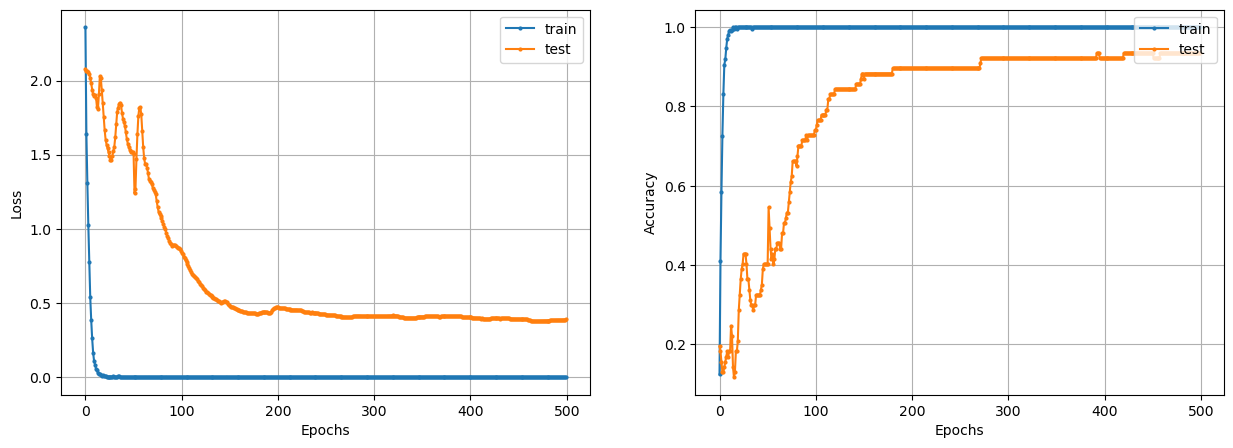

0.9350649118423462 0.3787814676761627
Start subject 17, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


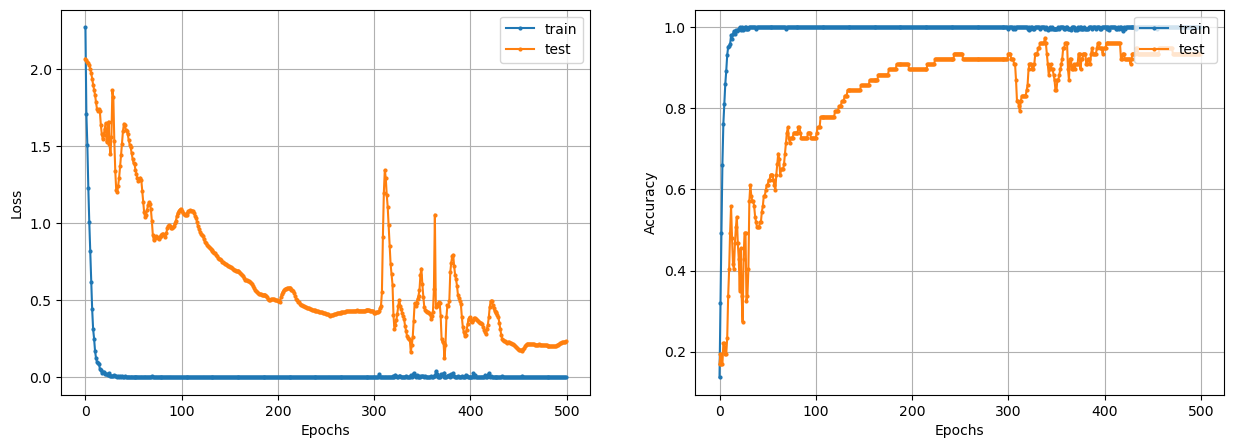

0.9740259647369385 0.12302599102258682
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


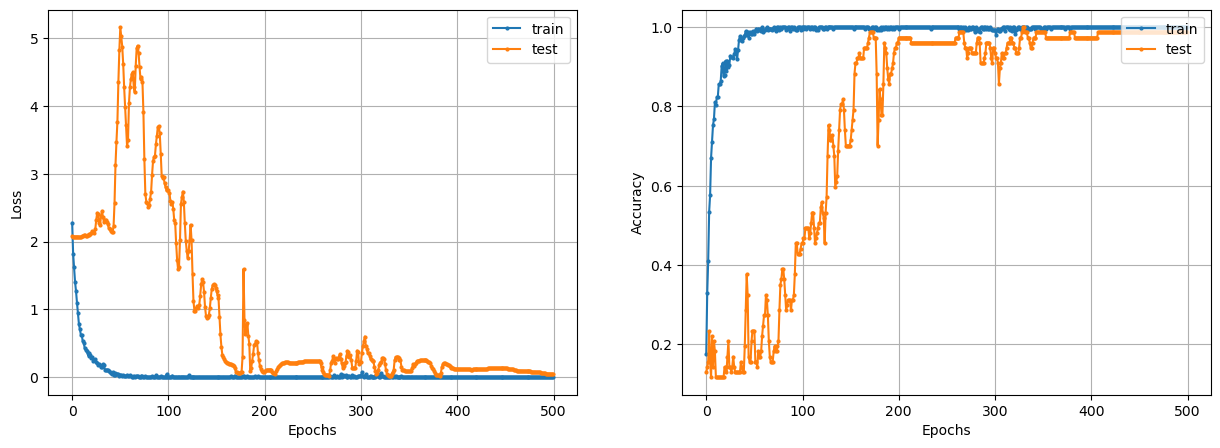

1.0 0.018498694524168968
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


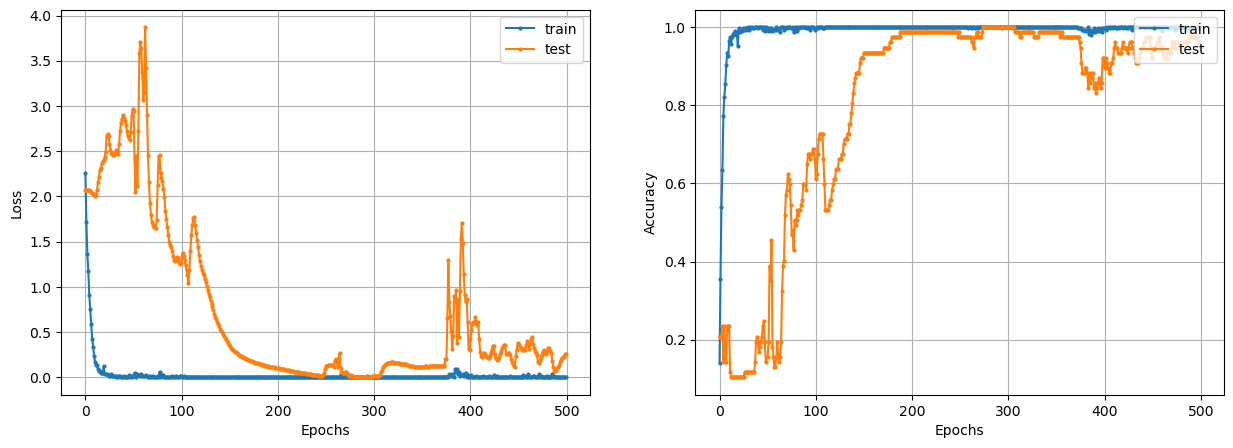

1.0 0.0038514710031449795
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


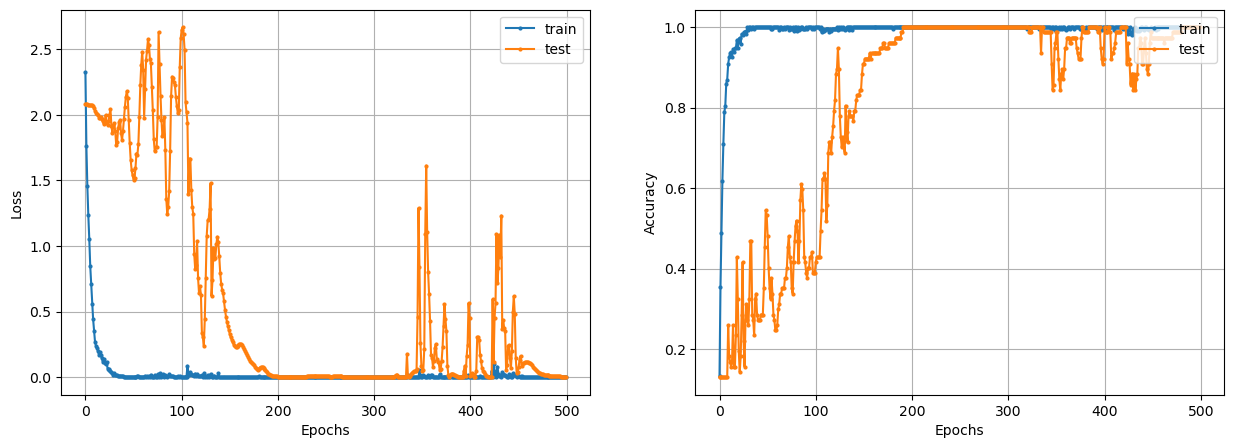

1.0 0.00010336305422242731
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


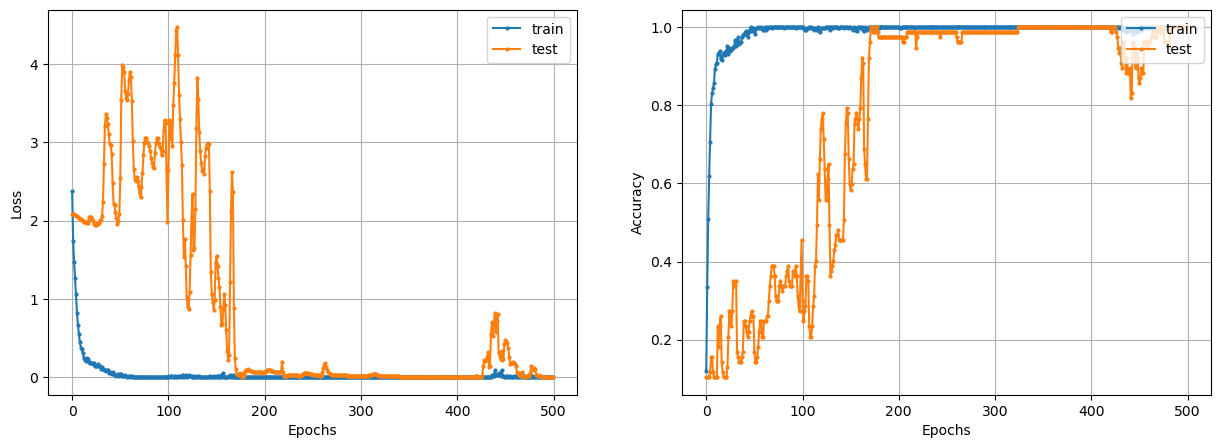

1.0 0.0001568283187225461
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


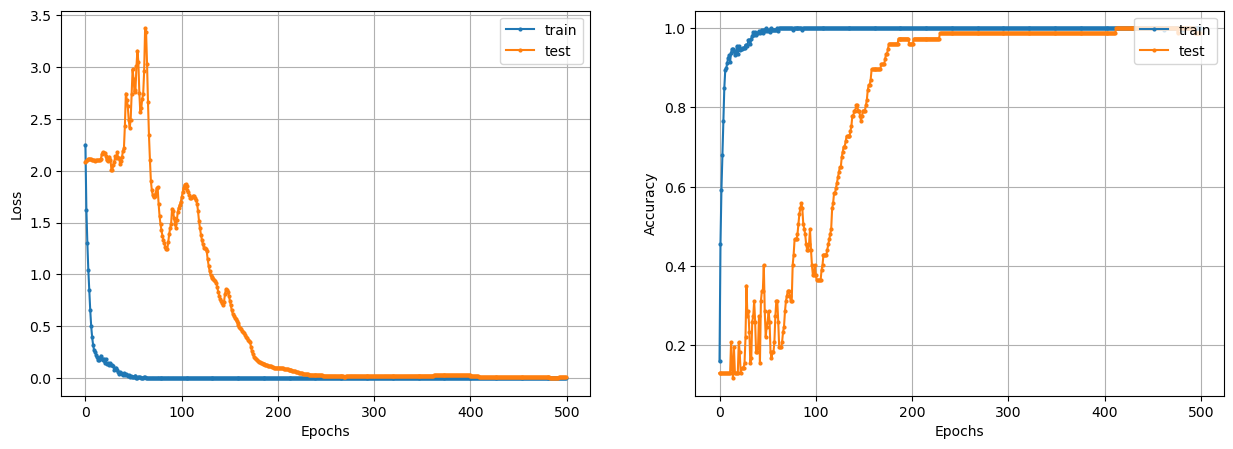

1.0 0.006257566623389721
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


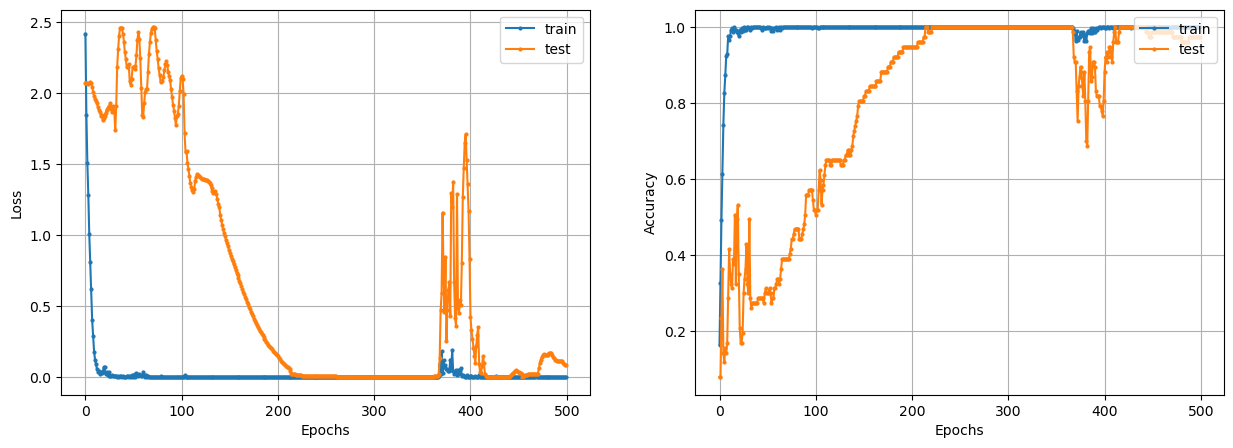

1.0 0.00035406509414315224
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


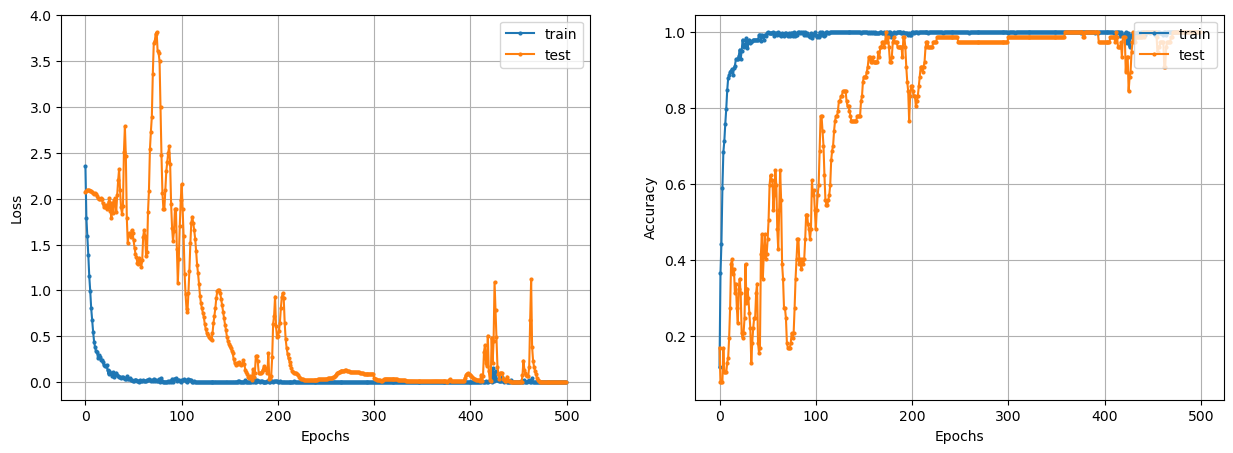

1.0 0.00012095478450646624
Start subject 18, Len: 16


Edges shape: (2, 3392)      Nodes shape: (384, 1000)


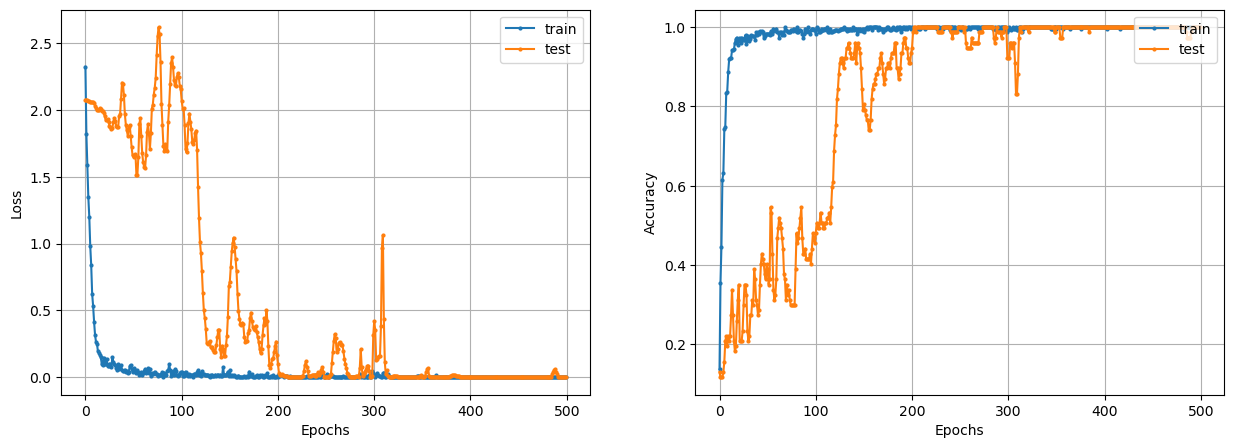

1.0 1.8788574379868805e-05


In [18]:
pat = './performance_vertical/'

for subject in range(15,19):
    for no_sen in range(8):
        LST_sensor = []
        for i in range(128):
            if i%8 == no_sen:
                LST_sensor.append(i)
        
        print("Start subject {}, Len: {}\n======================================================\n\n".format(subject, len(LST_sensor)))
        df = build_df(LST_sensor, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, LST_sensor)
        #draw_graph(graph)
        
        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                            #callbacks=[lr_scheduler,early_stopping],
                            verbose = 0)
        
        plot(val)
        
        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']
        print(np.max(ACC), np.min(LOSS))
        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_missing_sensors_7_Row{}.csv'.format(subject, no_sen))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_missing_sensors_7_Row{}.csv'.format(subject, no_sen))

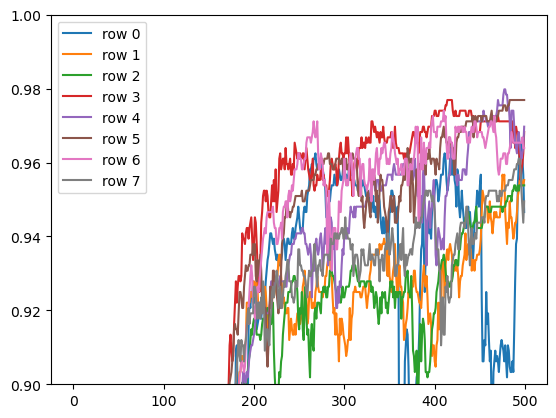

In [13]:
path = './performance_vertical/'


for i in range(8):
    ACC, LOSS = [], []
    for sub in range(1, 10):
        tmp = pd.read_csv(path + 'S{}/val_acc_missing_sensors_7_Row{}.csv'.format(sub, i))
        del tmp['Unnamed: 0']
        ACC.append(tmp.iloc[:,0].tolist())
    plt.plot(np.mean(np.array(ACC), axis=0), label='row {}'.format(i))
    
plt.legend()
plt.ylim(0.9,1)
plt.show()

# Erasing and assessing sensor quality

In [13]:
for subject in range(1):
    all_lst = np.arange(128).tolist()
    for no_sen in range(5):
        ACC, LOSS = [], []

        if no_sen == 0: pass
        elif no_sen == 5:
            for i in range(28): all_lst.remove(random.choice(all_lst))
                
        else:
            for i in range(25): all_lst.remove(random.choice(all_lst))
                
        print(len(all_lst))

128
103
78
53
28


Start subject 11, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


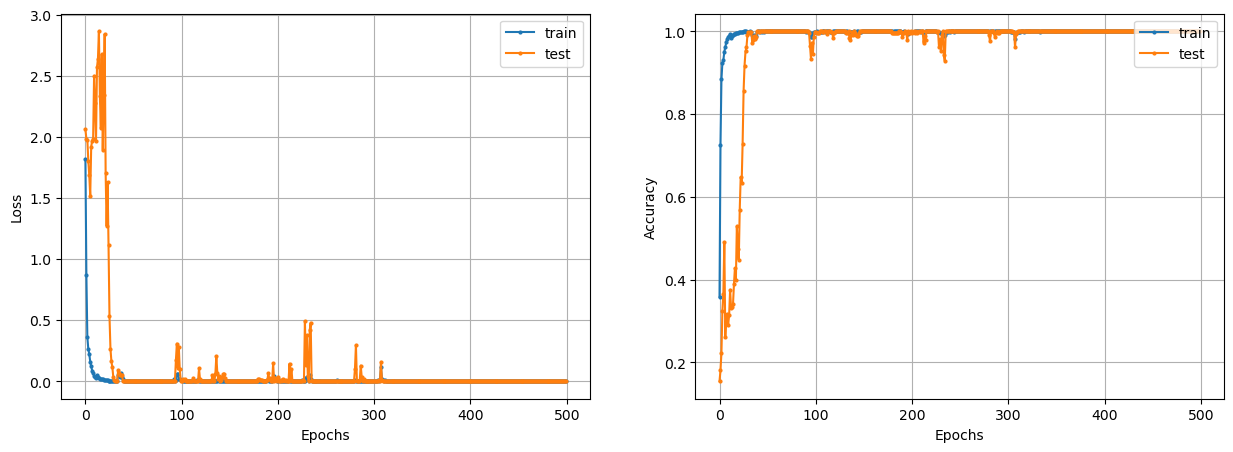

Start subject 11, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


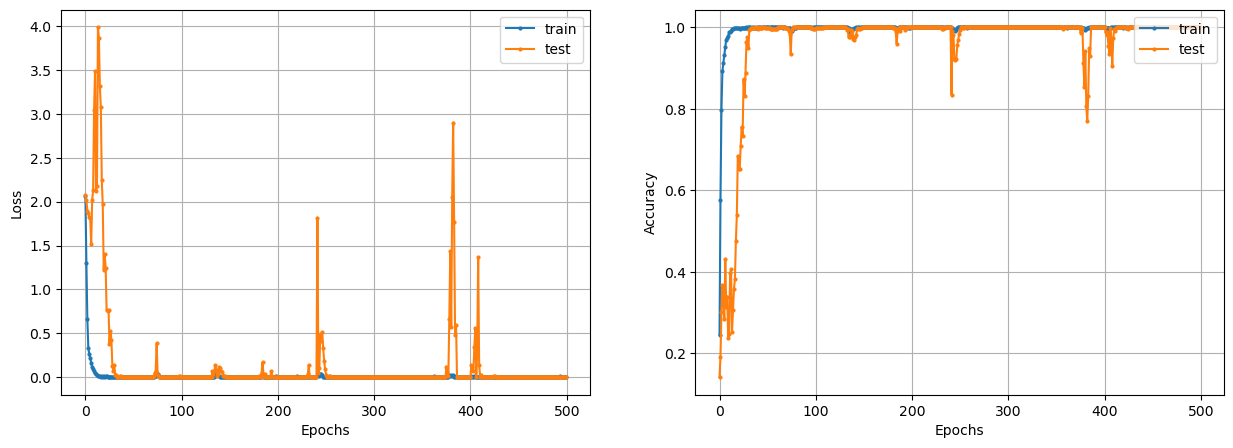

Start subject 11, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


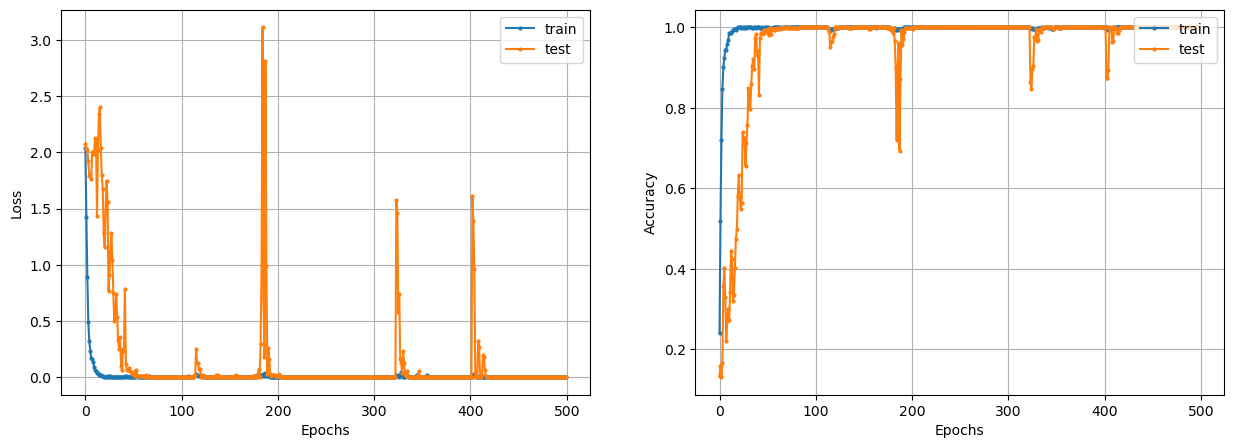

Start subject 11, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


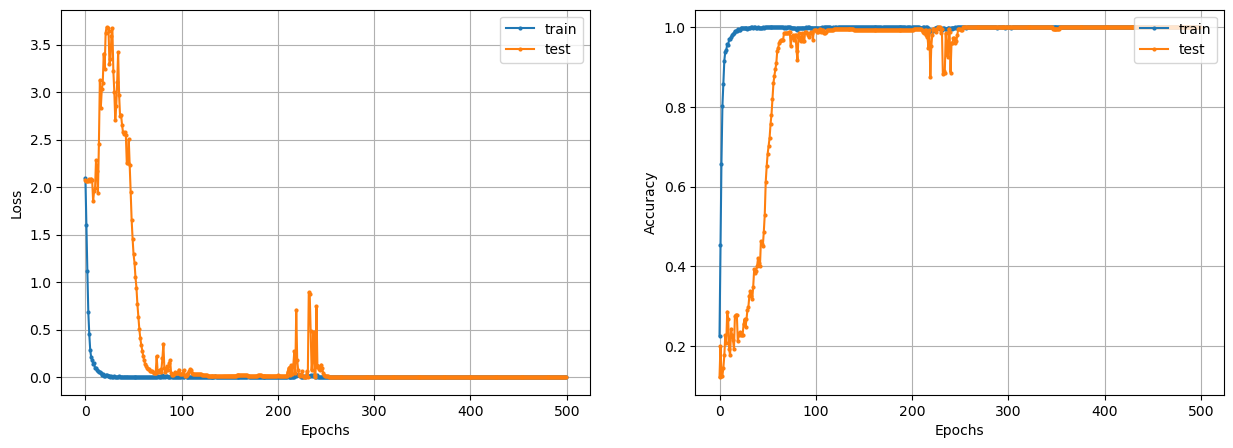

Start subject 11, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


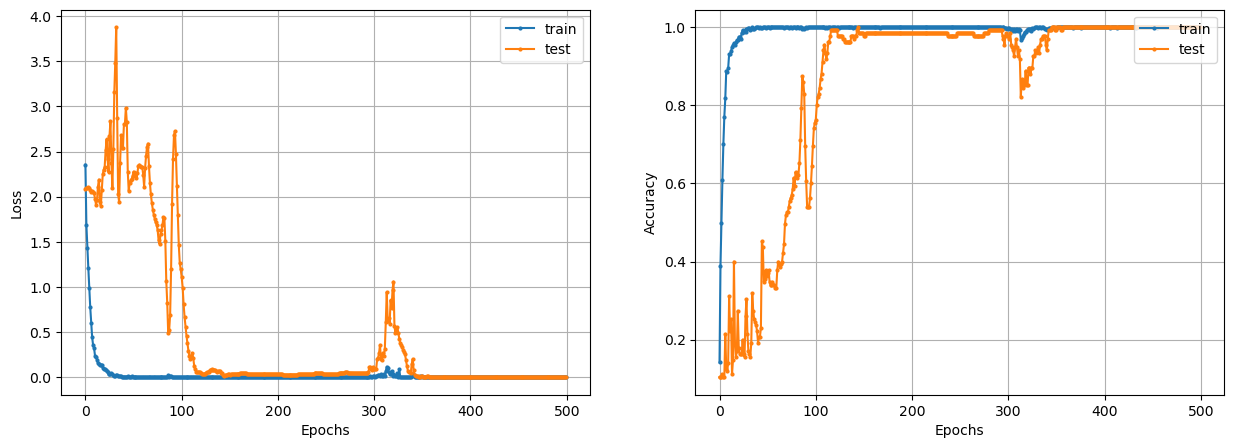

Start subject 12, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


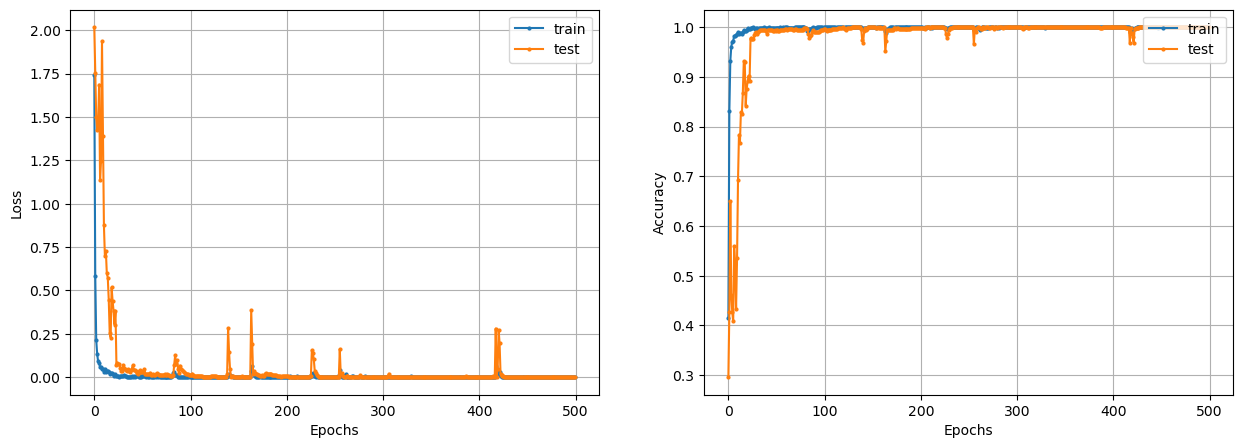

Start subject 12, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


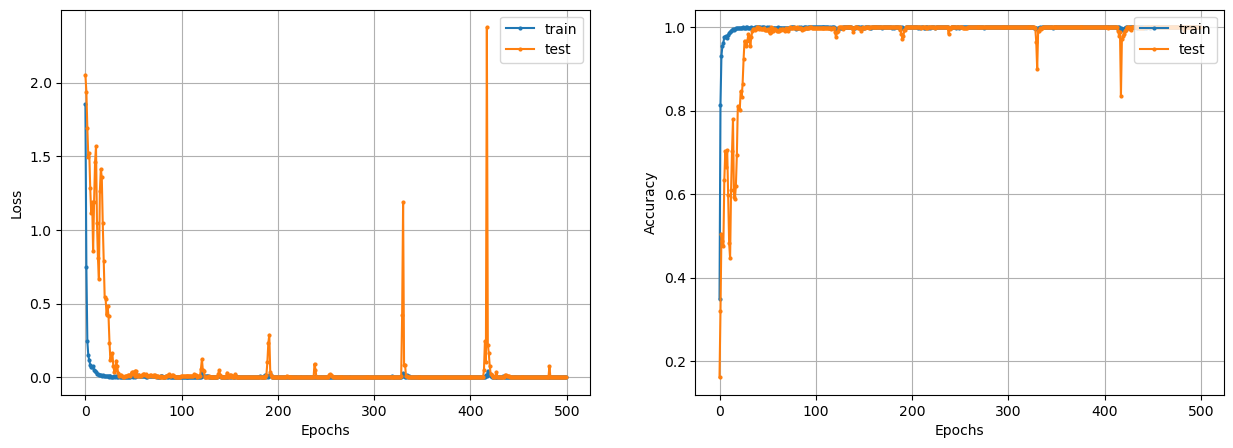

Start subject 12, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


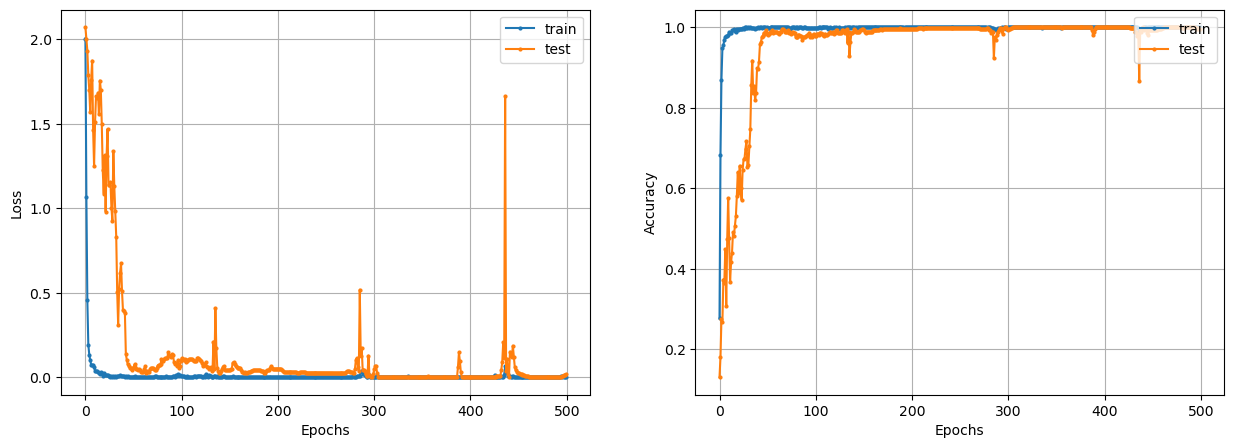

Start subject 12, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


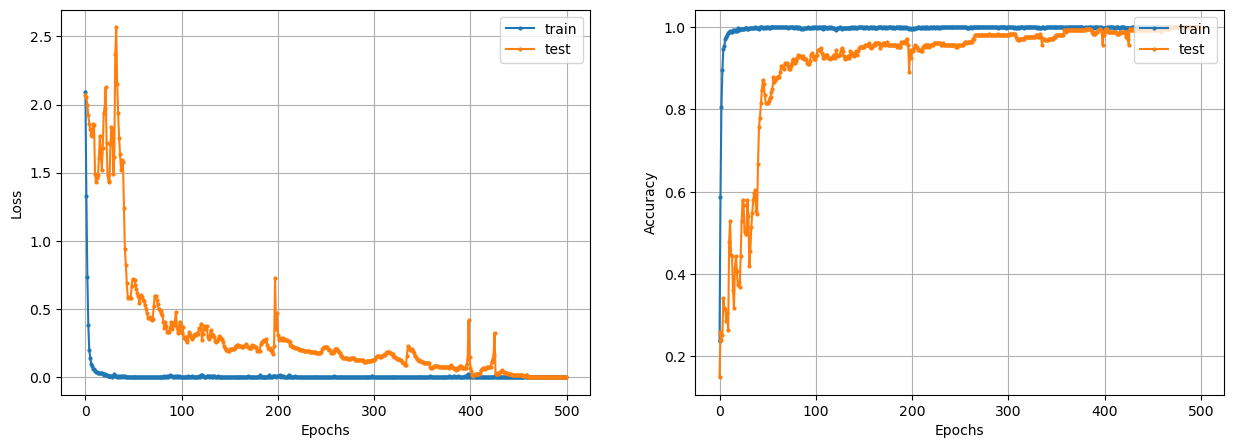

Start subject 12, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


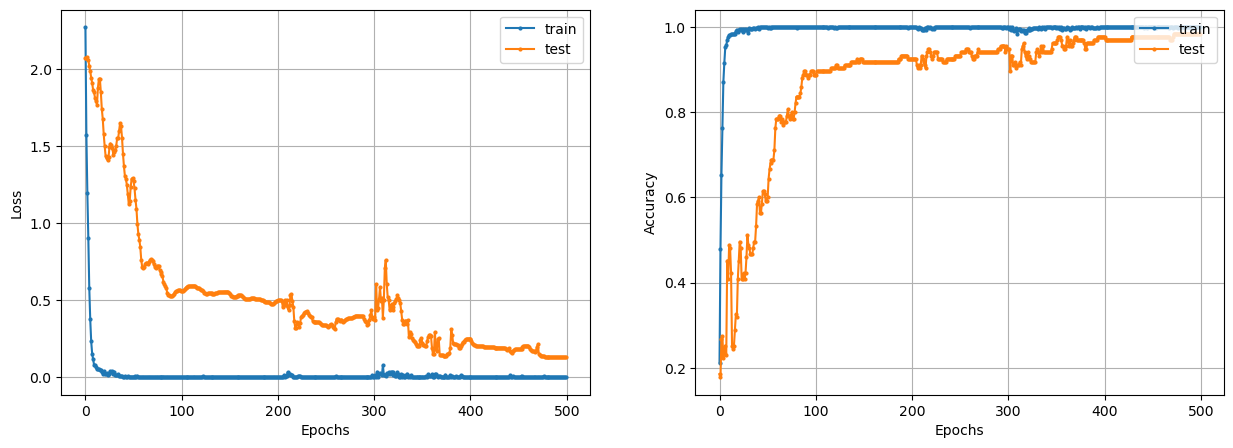

Start subject 13, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


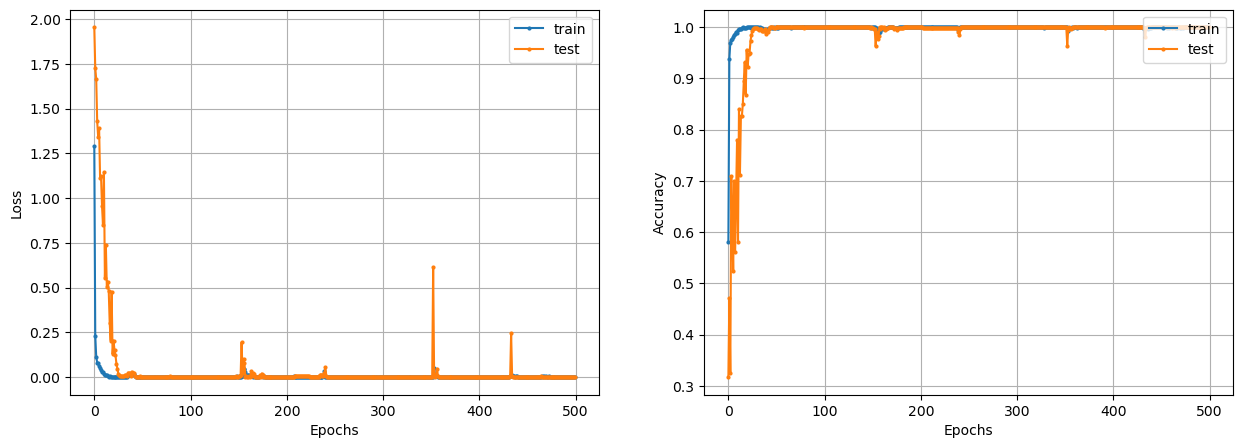

Start subject 13, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


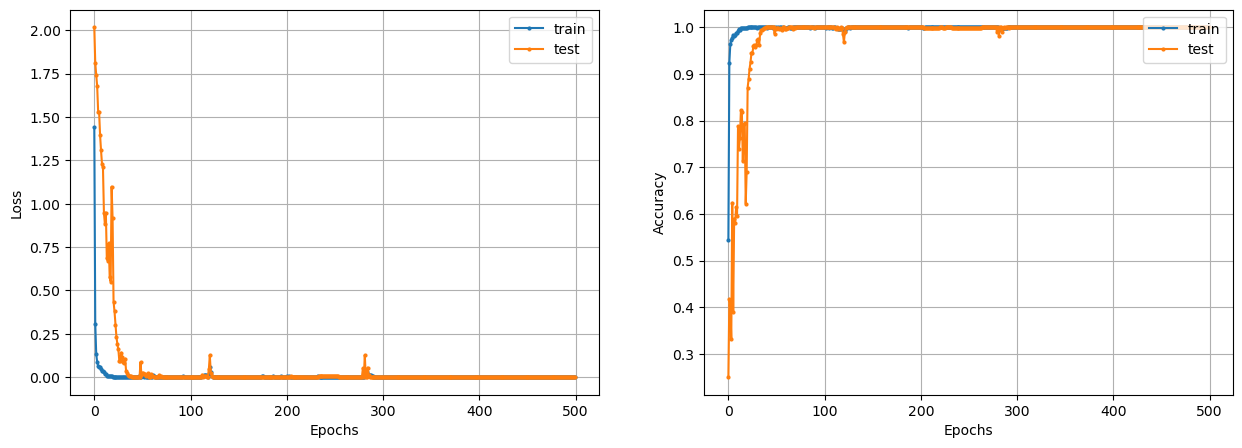

Start subject 13, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


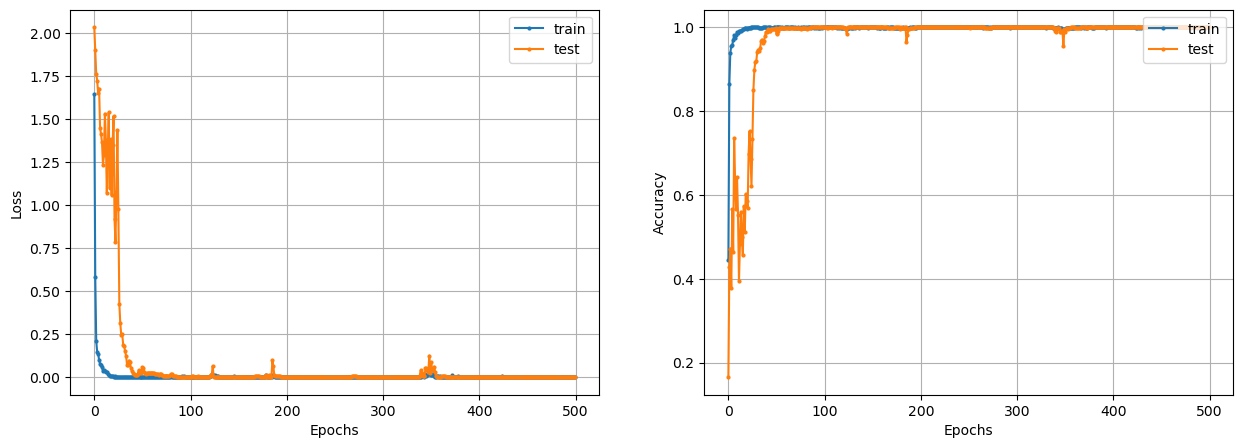

Start subject 13, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


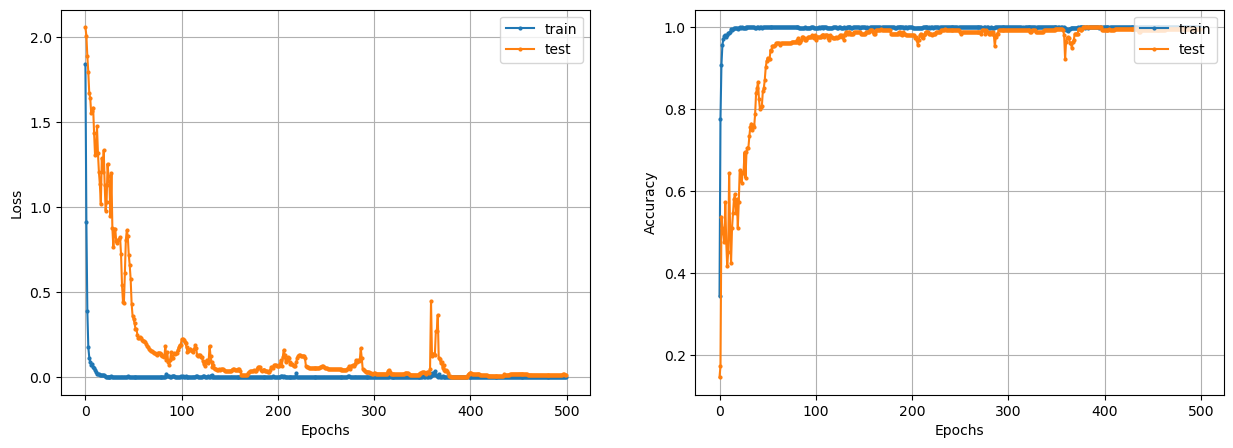

Start subject 13, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


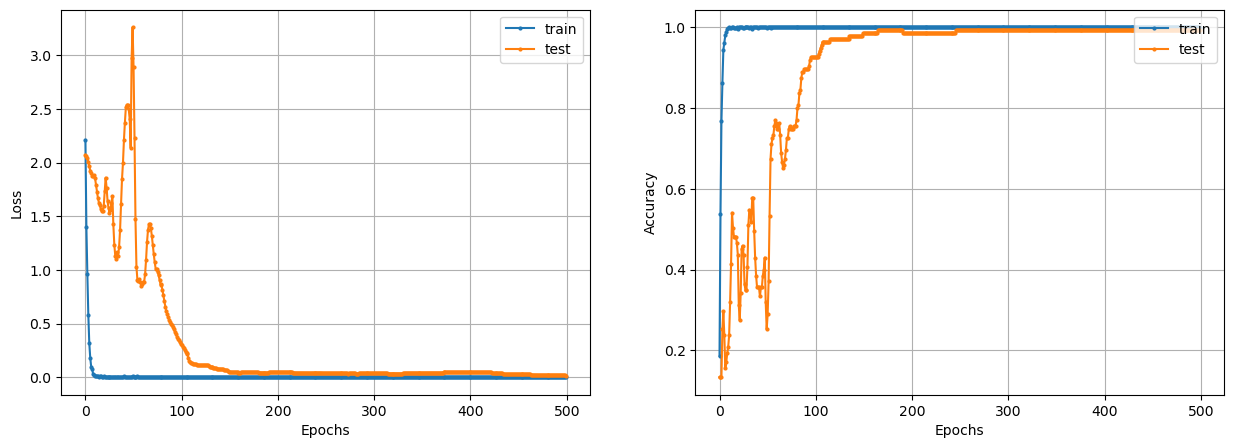

Start subject 14, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


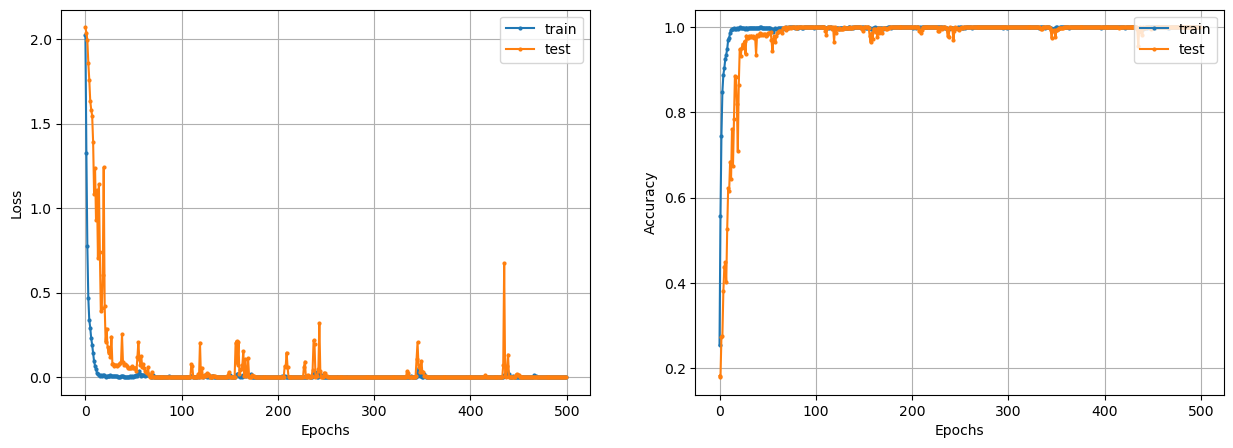

Start subject 14, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


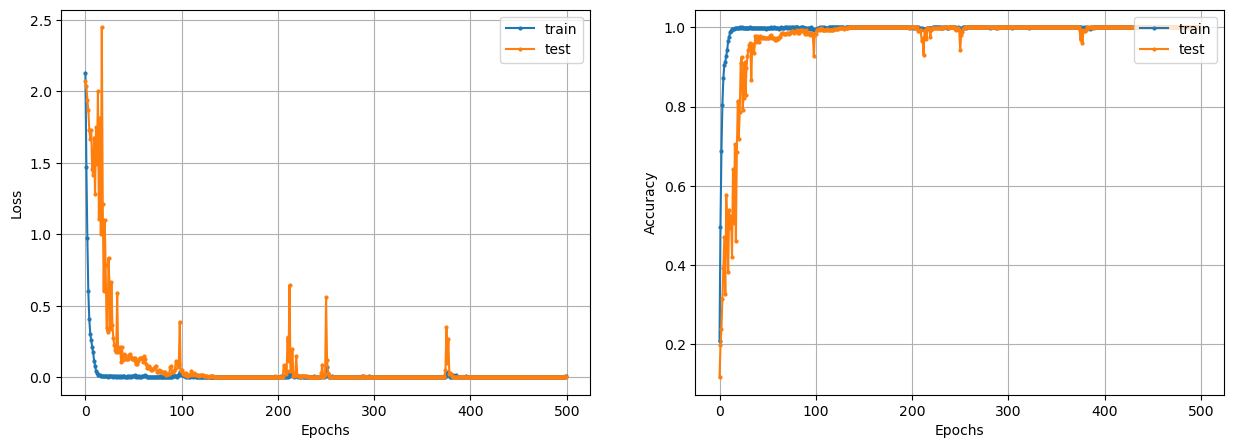

Start subject 14, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


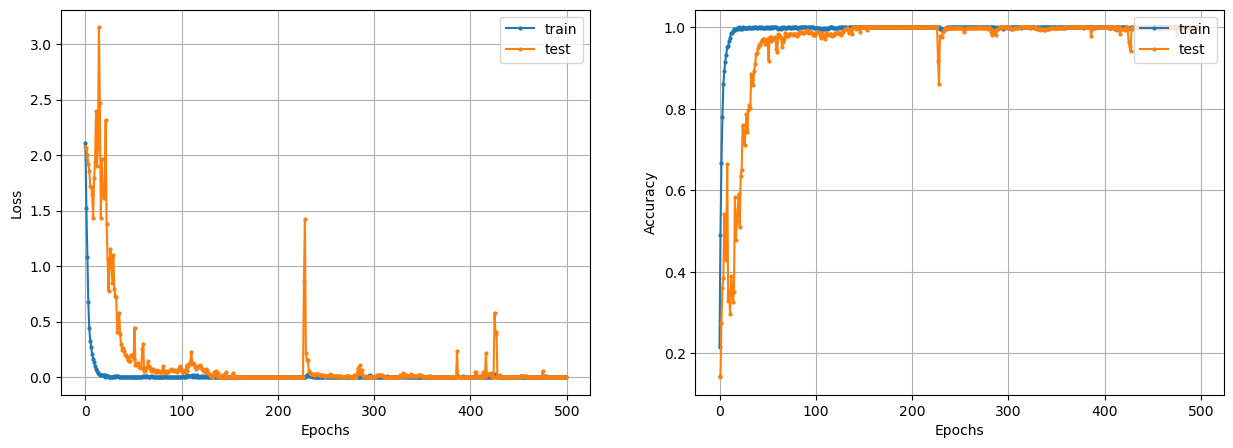

Start subject 14, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


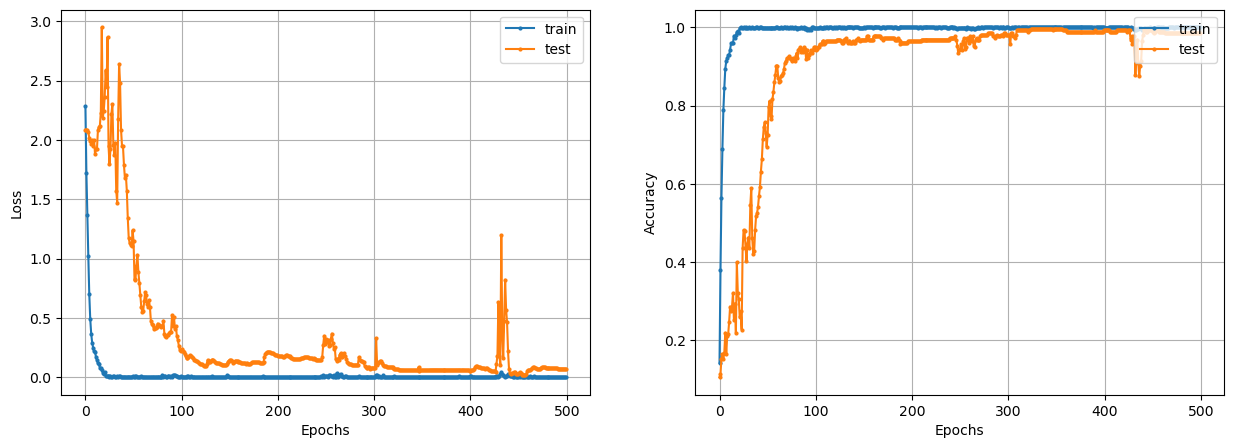

Start subject 14, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


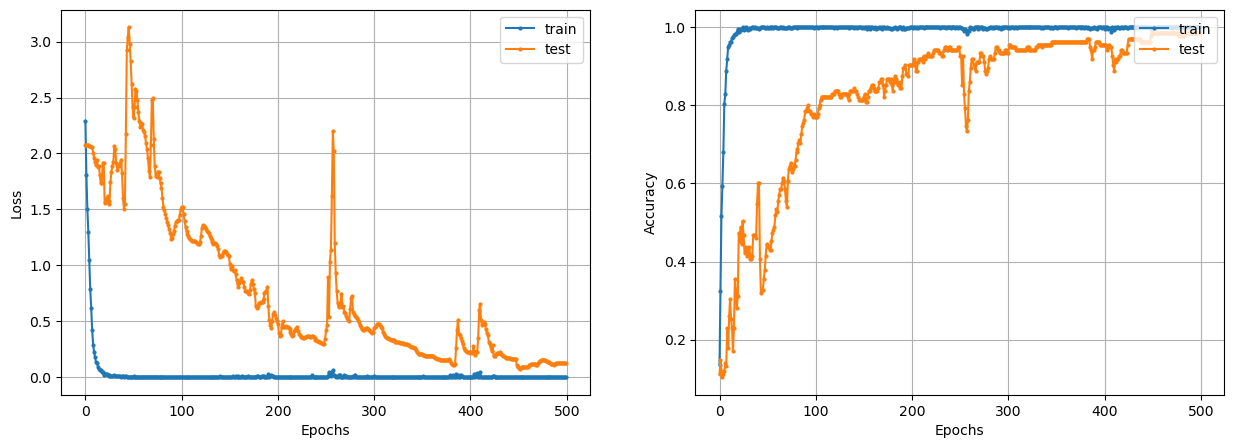

Start subject 15, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


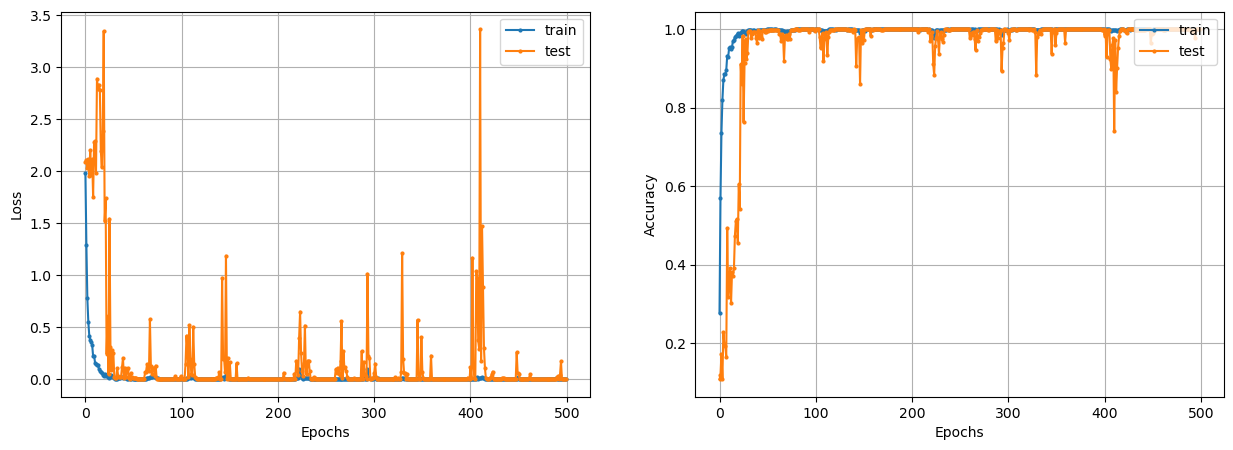

Start subject 15, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


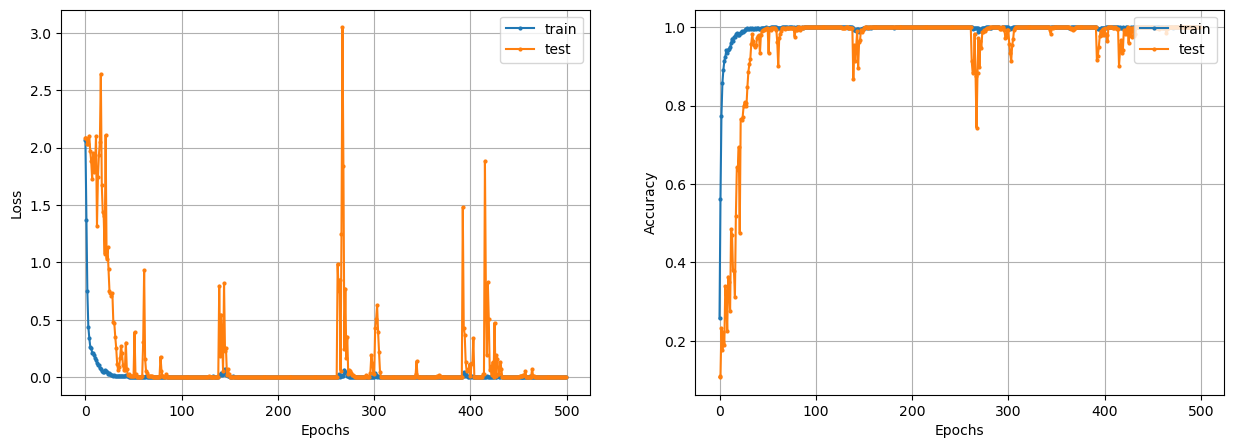

Start subject 15, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


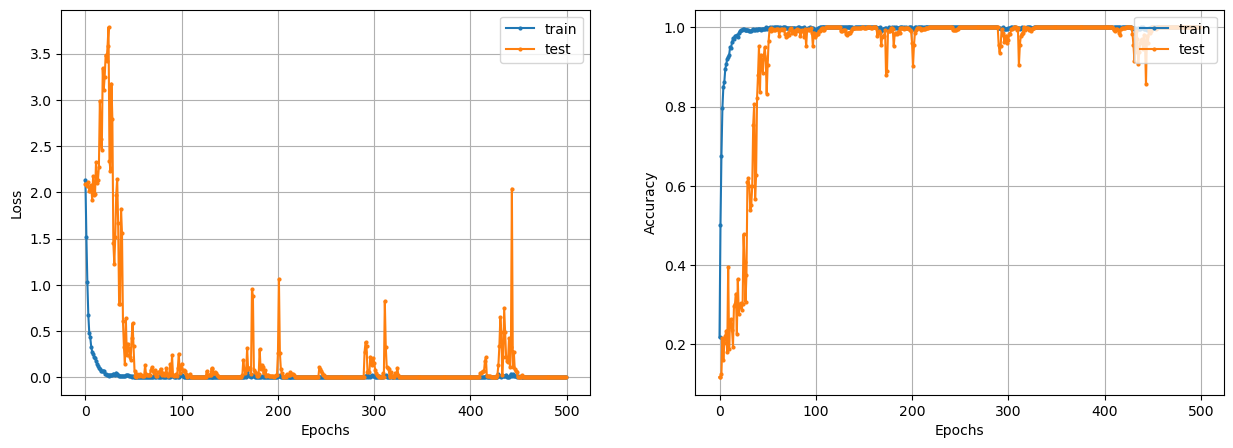

Start subject 15, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


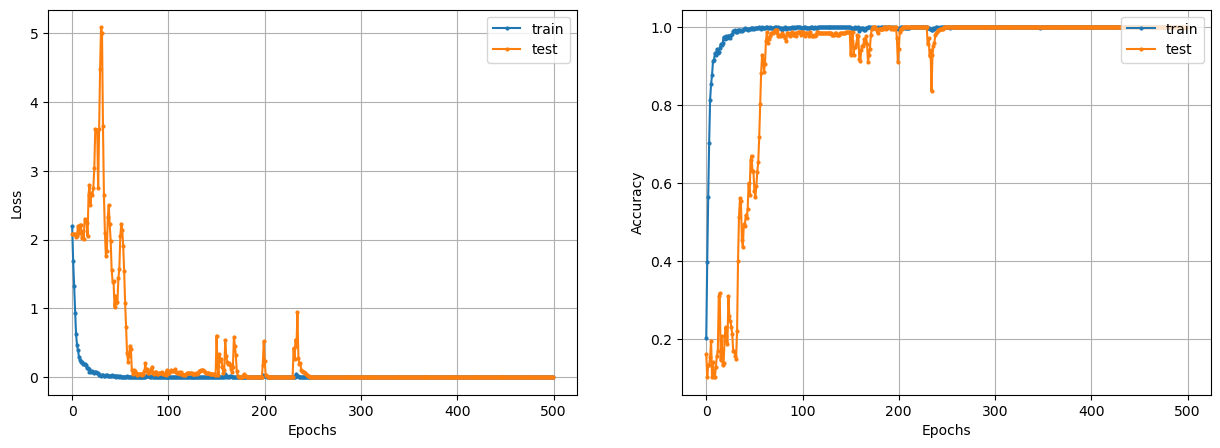

Start subject 15, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


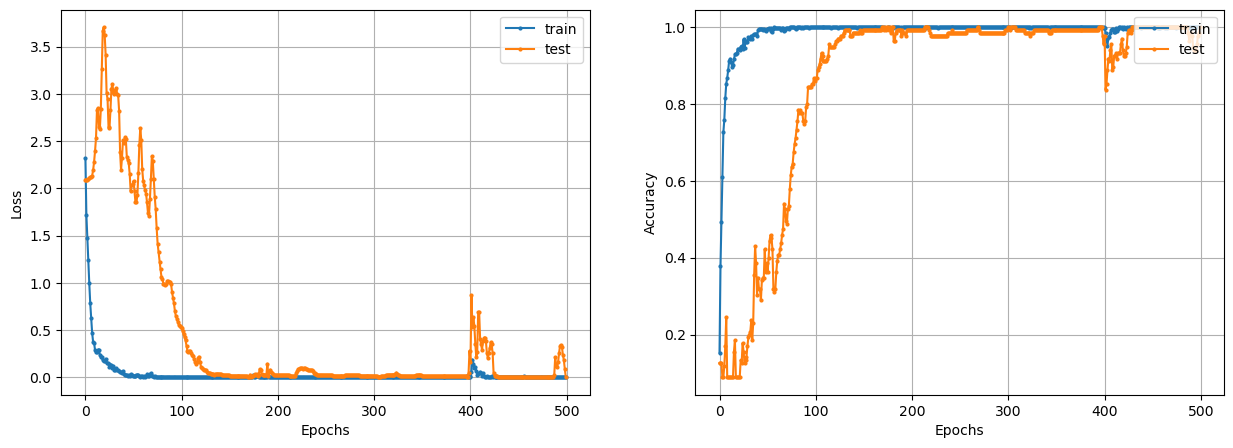

Start subject 16, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


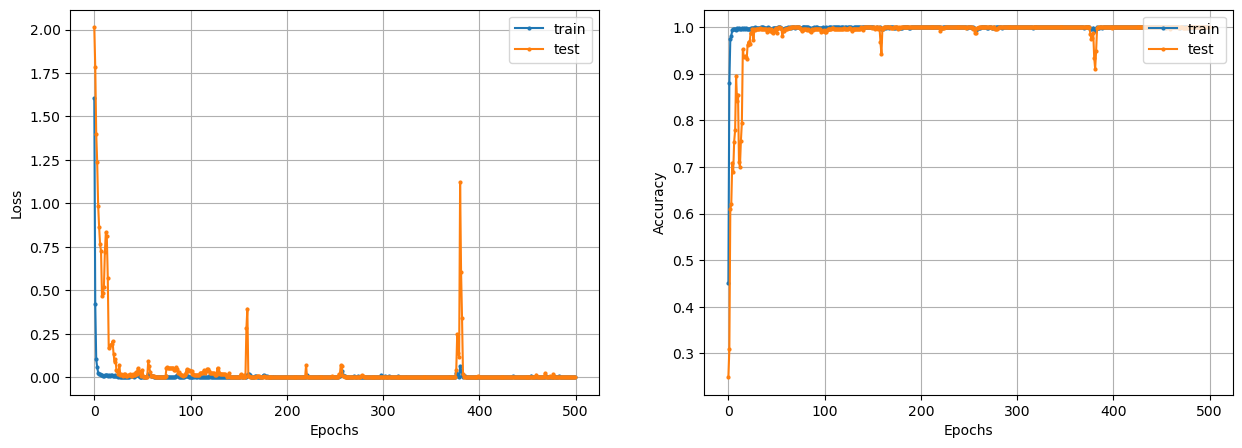

Start subject 16, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


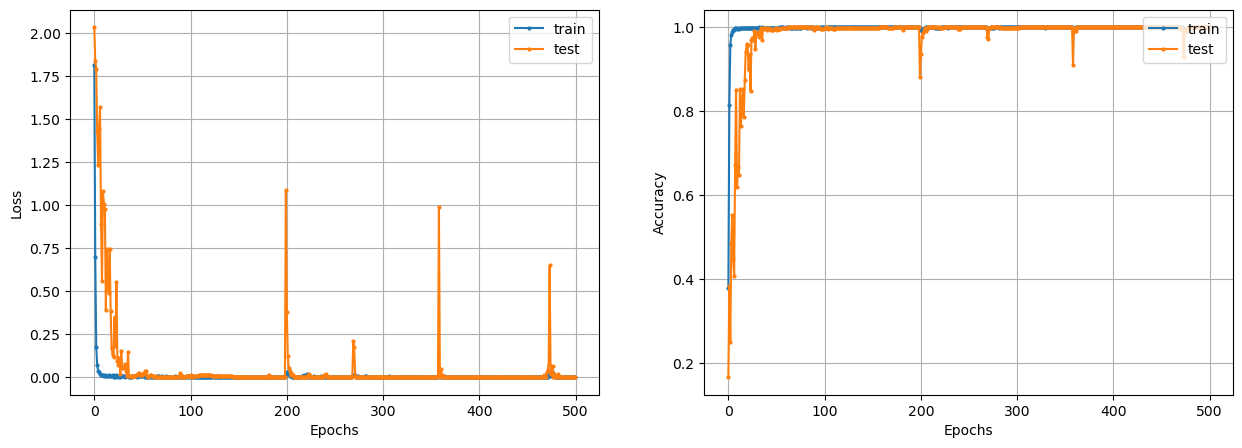

Start subject 16, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


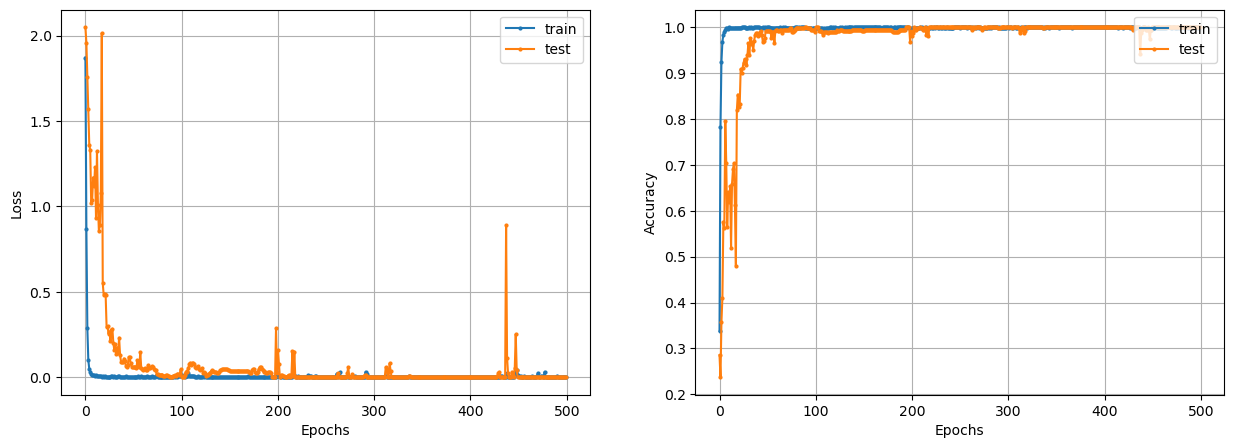

Start subject 16, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


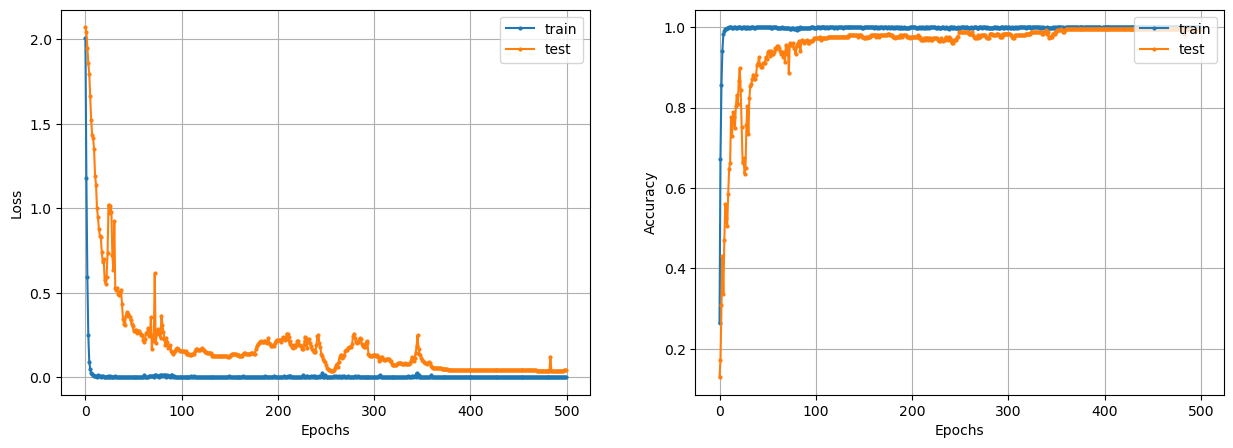

Start subject 16, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


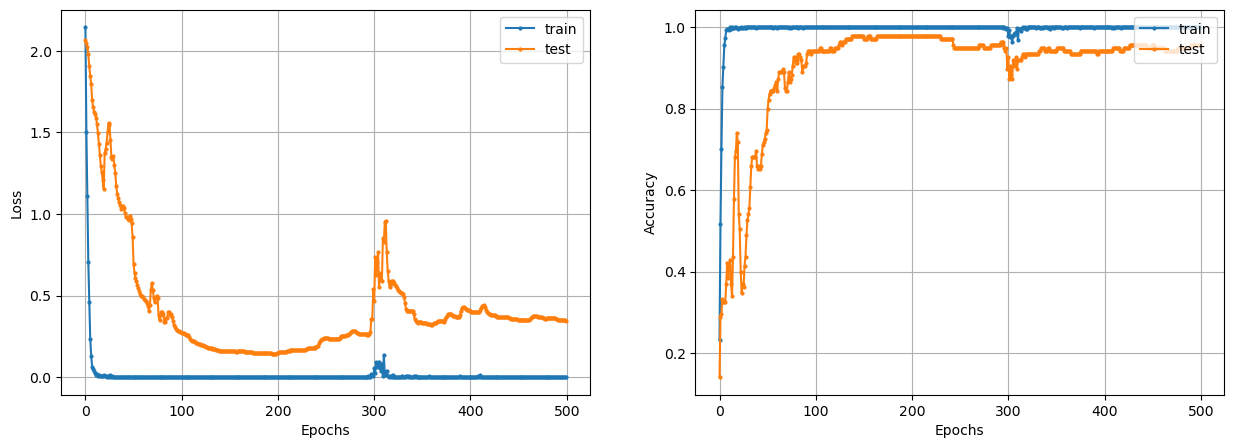

Start subject 17, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


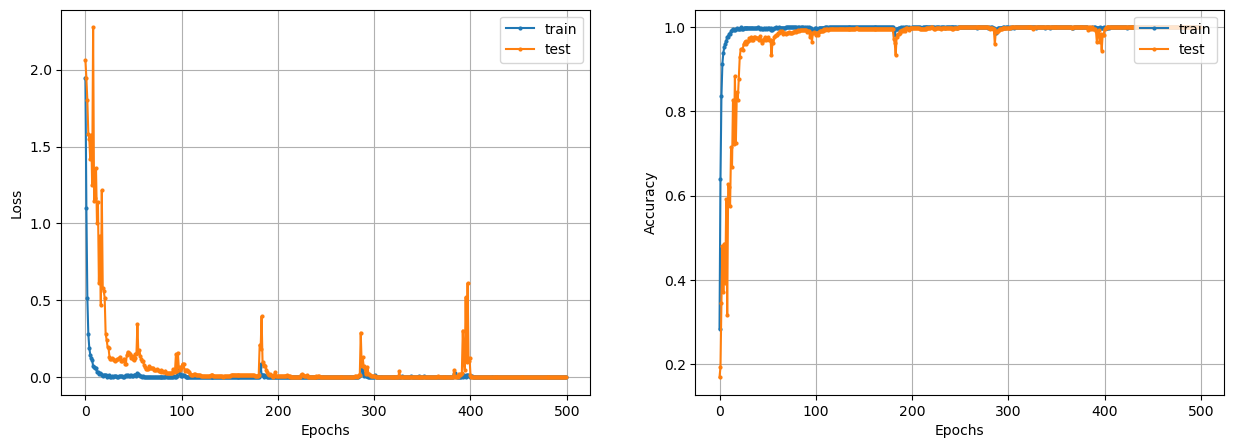

Start subject 17, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


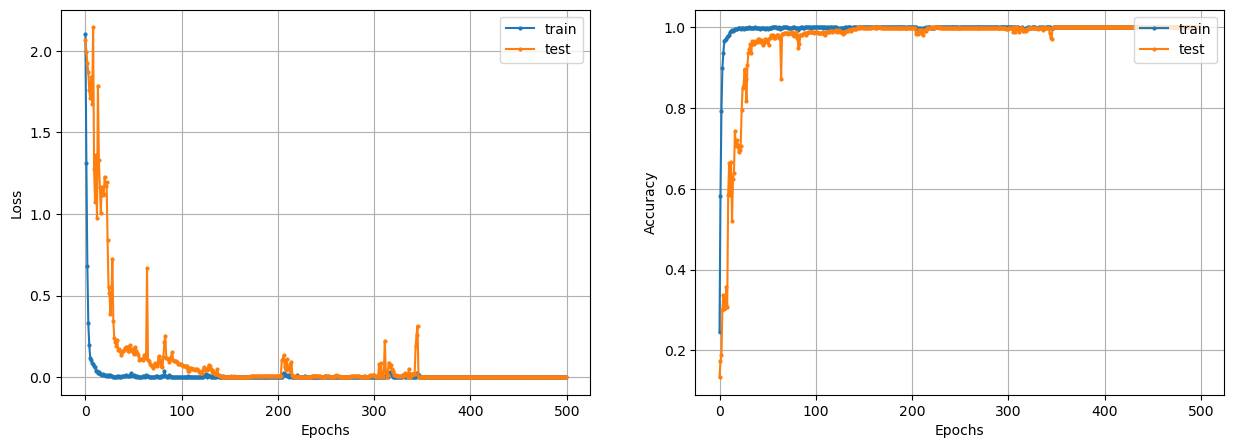

Start subject 17, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


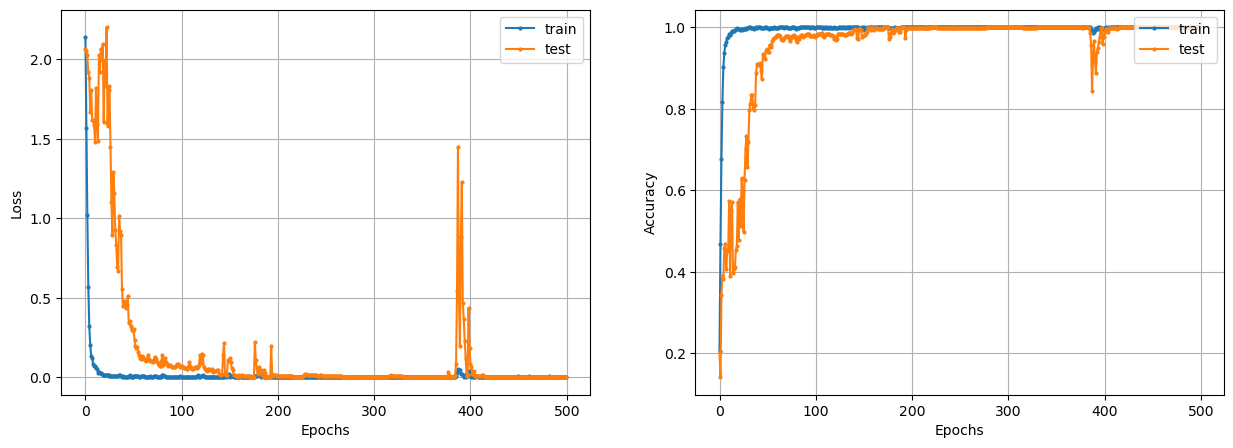

Start subject 17, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


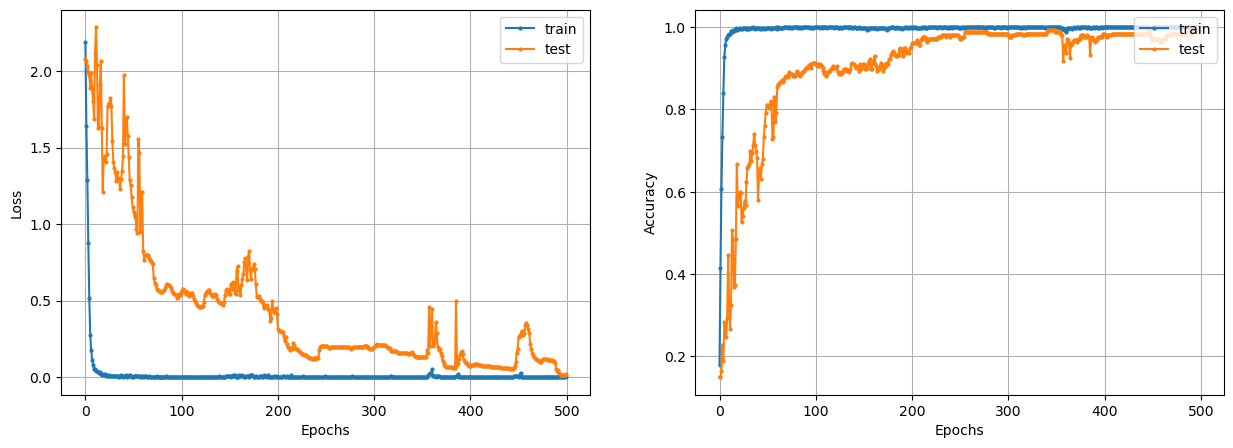

Start subject 17, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


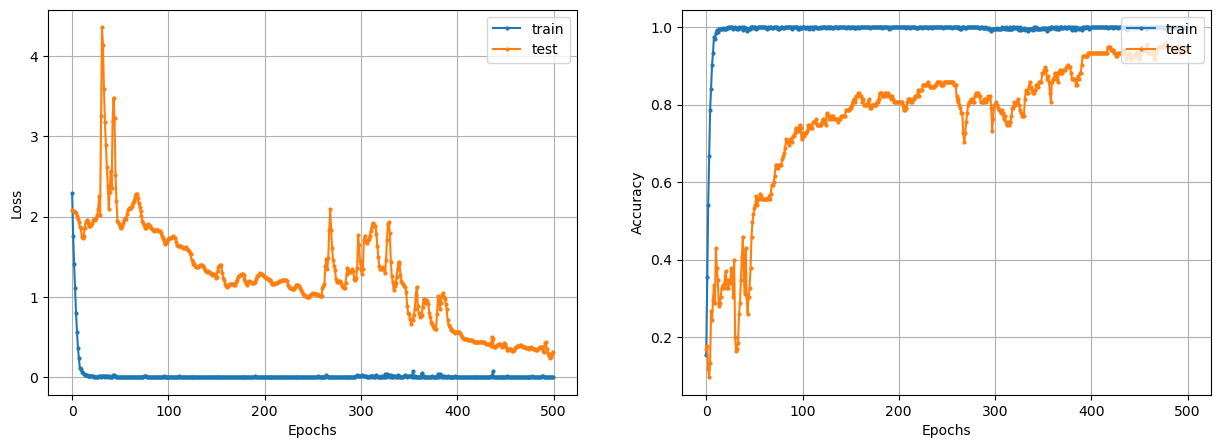

Start subject 18, Len: 128


Edges shape: (2, 25456)      Nodes shape: (3072, 1000)


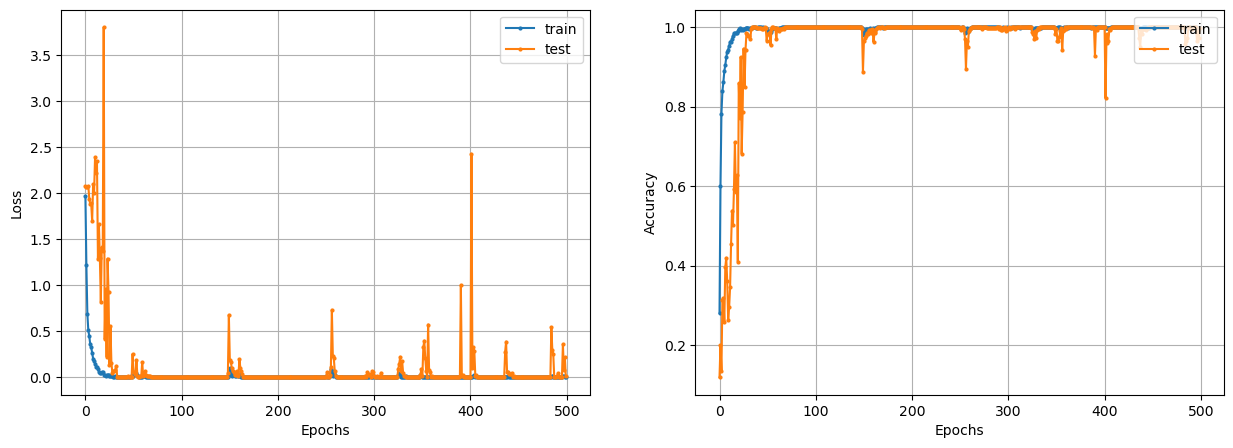

Start subject 18, Len: 103


Edges shape: (2, 20585)      Nodes shape: (2472, 1000)


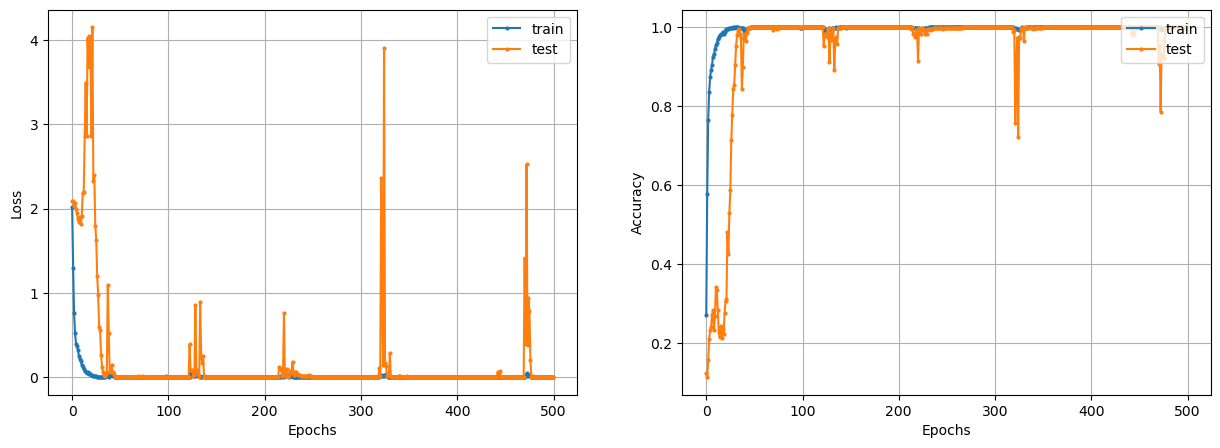

Start subject 18, Len: 78


Edges shape: (2, 15642)      Nodes shape: (1872, 1000)


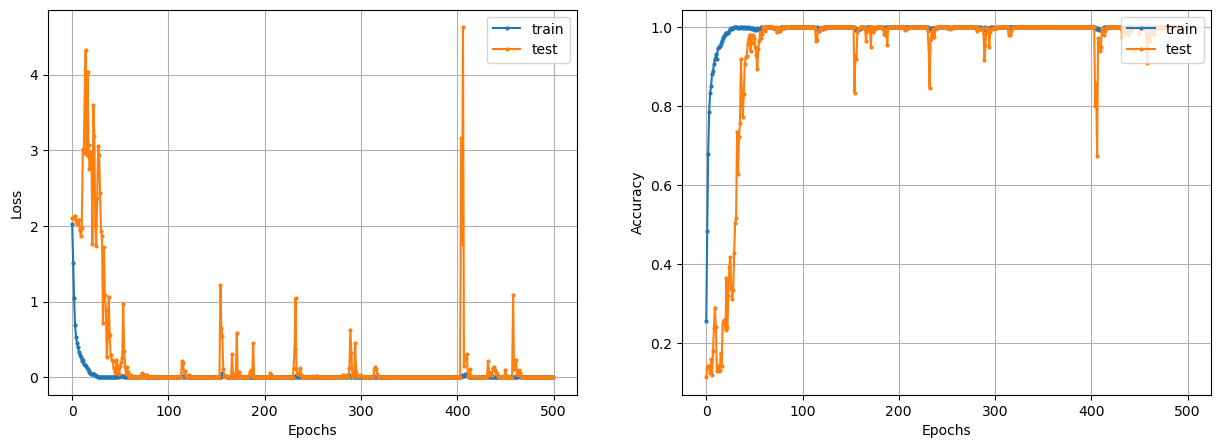

Start subject 18, Len: 53


Edges shape: (2, 10699)      Nodes shape: (1272, 1000)


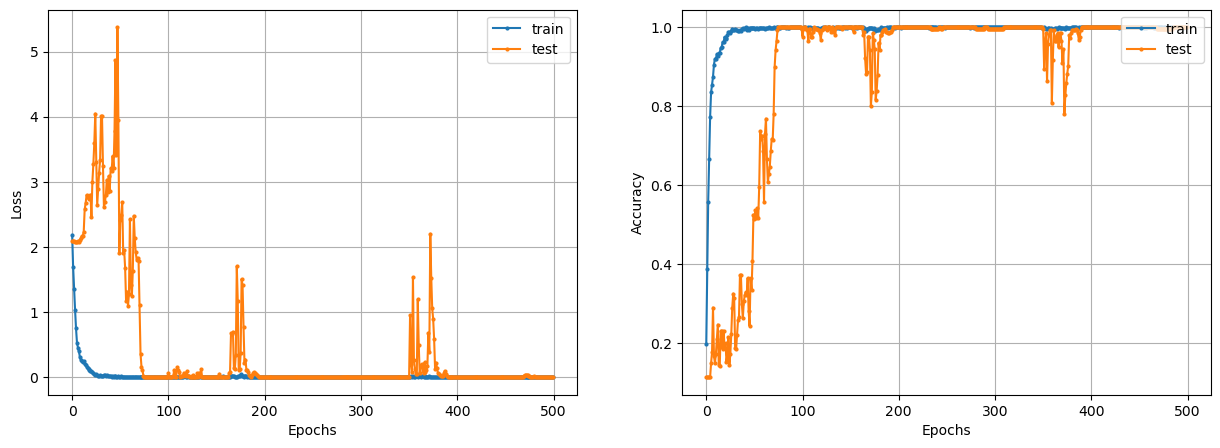

Start subject 18, Len: 28


Edges shape: (2, 5756)      Nodes shape: (672, 1000)


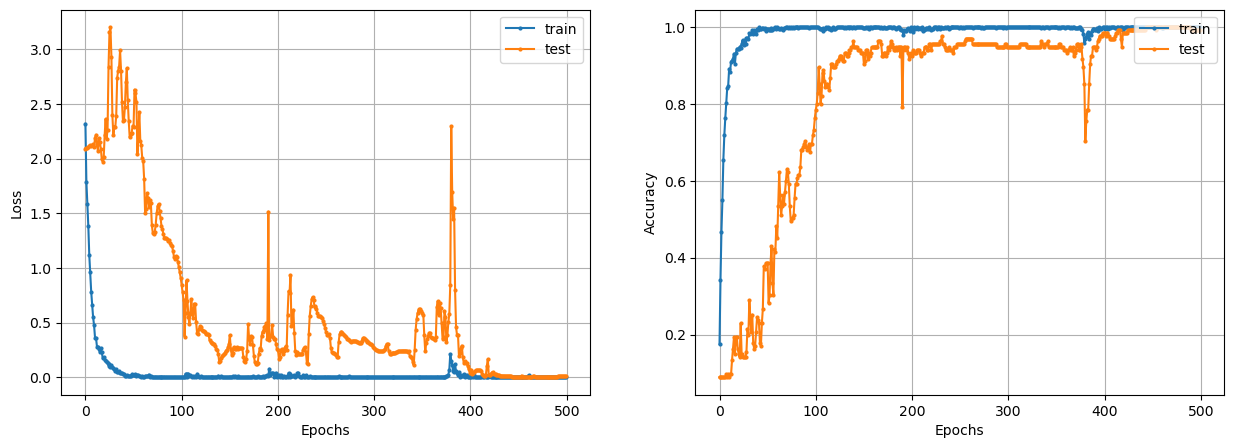

In [19]:
pat = './performance_reducing_rows_typeA/'

for subject in range(11,19):
    all_lst = np.arange(128).tolist()
    for no_sen in range(5):

        if no_sen == 0: pass
        elif no_sen == 5:
            for i in range(28): all_lst.remove(random.choice(all_lst))
                
        else:
            for i in range(25): all_lst.remove(random.choice(all_lst))                
        
        print("Start subject {}, Len: {}\n===========================================\n\n".format(subject, len(all_lst)))
        df = build_df(all_lst, subject)
        graph, graph_info, x_train, y_train = build_graph_works_larger_than_16(df, all_lst)

        gnn_model = build_gnn_model(graph_info, num_classes, hidden_units, dropout_rate)

        val = gnn_model.fit(x=x_train, y=y_train, epochs=500, batch_size=batch_size, validation_split=0.2,
                        #callbacks=[lr_scheduler,early_stopping],
                        verbose = 0)

        plot(val)
        ACC = val.history['val_acc']
        LOSS = val.history['val_loss']

        pd.DataFrame(ACC).to_csv(pat+'S{}/val_acc_having_sensors{}.csv'.format(subject, len(all_lst)))
        pd.DataFrame(LOSS).to_csv(pat+'S{}/val_loss_having_sensors{}.csv'.format(subject, len(all_lst)))